# Assignment 2

__41934 - Advanced BIM, E23__


Kaare G. S. Hansen, s214282 - DTU




BIM ideer:
- Byg etager oven på hindanden, forstør søjler etc...
- Ændre nyttelast i spaces, lav ny geometri, lav FEM-model
- Opennest, produktionstegninger

## Todo

- [ ] Bounding box to plane
- [ ] Project wall and slab to plane, generate mesh
- [ ] Beam/Column, lines, find common FEM-knots
- [ ] Connect wall/slab mesh to beam/columns
- [ ] Apply self-weight load
- [ ] Apply load from IfcSpaces/zones
- [ ] Create IfcStructuralAnalysisModel
- [ ] Analyse IfcStructuralAnalysisModel with PyNiteFEA
- [ ] Brug IFC-load method fra kursus

**Todo nu**:
- ~~[ ] Plotly af guids~~
- [ ] Find samling af bjælker, søjler til udviklingseksempel
- [ ] Abstract base class til analyticalModel


## Ideas
- Detect knots by end of beam/column lines
- Detect knots by enlarging obb slightly and doing checks..

## Limitations
- All analytical connections have zero DOF
- 

## Imports

In [1]:
import os
import sys
import multiprocessing
import importlib
from collections import namedtuple
import numpy as np
import pandas as pd
import ifcopenshell
import ifcopenshell.util.placement
import ifcopenshell.geom
import ifcopenshell.util.shape
import ifcopenshell.util.selector

print(f"ifcopenshell version: {ifcopenshell.version}")
print(f"Python-version {sys.version}")

ifcopenshell version: 0.7.0
Python-version 3.11.5 | packaged by Anaconda, Inc. | (main, Sep 11 2023, 13:26:23) [MSC v.1916 64 bit (AMD64)]


In [2]:
from geomUtils import *
from ifcUtils import *
from rendering import *
import geomUtils
import ifcUtils
import rendering
import utils

In [3]:
from OCC.Core.BRepPrimAPI import BRepPrimAPI_MakeBox
from OCC.Core.gp import gp_Pnt, gp_Ax2, gp_Dir, gp_XYZ
from OCC.Core.BRepBndLib import brepbndlib
from OCC.Core.BRepBuilderAPI import BRepBuilderAPI_MakeVertex
from OCC.Core.Bnd import Bnd_OBB
from OCC.Core.BRepTools import breptools_Read
from OCC.Core.TopoDS import TopoDS_Shape, TopoDS_Wire
from OCC.Core.BRep import BRep_Builder
from OCC.Core.GC import GC_MakeArcOfCircle, GC_MakeSegment

from OCC.Display.SimpleGui import init_display
from OCC.Display.OCCViewer import rgb_color

from OCC.Core.gp import gp_Pnt, gp_Dir, gp_Lin
from OCC.Core.Geom import Geom_Line, Geom_Point, Geom_CartesianPoint
from OCC.Core.AIS import AIS_Line, AIS_Point
from OCC.Core.Prs3d import Prs3d_LineAspect, Prs3d_Drawer
from OCC.Core.Quantity import Quantity_Color, Quantity_TOC_RGB
from OCC.Core.Graphic3d import Graphic3d_ZLayerSettings
from OCC.Core.TColStd import TColStd_SequenceOfInteger

import OCC.Core.BRep
import OCC.Core.BRepPrimAPI
import OCC.Core.BRepTools

from OCC.Core.gp import gp_Pnt
from OCC.Core.TopoDS import TopoDS_Vertex
from OCC.Core.BRepBuilderAPI import BRepBuilderAPI_MakeVertex
from OCC.Core.BRep import BRep_Tool
from OCC.Core.TopExp import TopExp_Explorer
from OCC.Core.TColgp import TColgp_Array1OfPnt
from OCC.Core.BRepAdaptor import BRepAdaptor_Curve
from OCC.Core.BRepExtrema import BRepExtrema_DistShapeShape

from OCC.Core.Prs3d import Prs3d_Text
from OCC.Core.Graphic3d import Graphic3d_Group, Graphic3d_Text
from OCC.Core.TCollection import TCollection_AsciiString, TCollection_ExtendedString
from OCC.Core.Quantity import Quantity_Color
from OCC.Core.gp import gp_Pnt
from OCC.Core.Aspect import Aspect_TOL_SOLID
from OCC.Core.AIS import AIS_TextLabel

from OCC.Core.BRepAlgoAPI import BRepAlgoAPI_Common, BRepAlgoAPI_Section, BRepAlgoAPI_BooleanOperation
from OCC.Core.BRepPrimAPI import BRepPrimAPI_MakeWedge
from OCC.Core.gp import gp_Pnt
from OCC.Core.BRepPrimAPI import BRepPrimAPI_MakeBox
from OCC.Core.BRepMesh import BRepMesh_IncrementalMesh
from OCC.Core.BRepExtrema import BRepExtrema_ShapeProximity

In [4]:
import plotly.graph_objects as go
import plotly.express as px
import plotly.io as pio
# pio.renderers.default = "png"
pio.renderers.default = "plotly_mimetype+png"

## Load models

In [5]:
models = load_models(model_dir='/Users/Kaare/My Drive/DTU/Kurser/Videregaaende BIM - 41934/IFC-models\SkyLab',
                     models={'ark': 'LLYN - ARK.ifc',
                             'stru': 'LLYN - STRU.ifc',
                             })

File path, ark: /Users/Kaare/My Drive/DTU/Kurser/Videregaaende BIM - 41934/IFC-models\SkyLab\LLYN - ARK.ifc
Model schema: IFC4

File path, stru: /Users/Kaare/My Drive/DTU/Kurser/Videregaaende BIM - 41934/IFC-models\SkyLab\LLYN - STRU.ifc
Model schema: IFC4



In [6]:
# models = load_models(model_dir='/Users/Kaare/My Drive/DTU/Kurser/Videregaaende BIM - 41934/IFC-models\Molio',
#                      models={#'ark': 'LLYN - ARK.ifc',
#                              'stru': 'BIMTypeCode - Referencemodel - 2022DK.ifc',
#                              })

In [7]:
model = models['stru']
# model = models['ark']

In [8]:
modelData = ModelData(model)

Beginning processing with 12 threads...
Progress: 1%
Progress: 28%
Progress: 32%
Progress: 44%
Progress: 100%
Progress: 100%
Progress: 100%
Progress: 100%
Processed 3601 items
Contexts: {'Axis', 'Body', 'FootPrint'}


In [9]:
elements = list(ifcopenshell.util.selector.filter_elements(model,
    "IfcBuildingElement, /Pset_.*Common/.LoadBearing=TRUE"))

elements_loadBearing = {element.GlobalId for element in elements}

elements = list(ifcopenshell.util.selector.filter_elements(model,
    "IfcBuildingElement, /Pset_.*Common/.LoadBearing=FALSE"))

elements_nonloadBearing = {element.GlobalId for element in elements}

elements = model.by_type('IfcBuildingElement')
elements_all = {element.GlobalId for element in elements}

elements = {element.GlobalId: element for element in elements}

print(len(elements_loadBearing))
print(len(elements_nonloadBearing))
print(len(elements_all))

1750
10
1835


In [10]:
elements_nonloadBearing = elements_all.difference(elements_loadBearing)
print(len(elements_nonloadBearing))

85


In [11]:
def NonLoadRenderFunc(renderer, **args):
    """Render a bunch of shapes"""

    modelData = args['modelData']
    GUIDS_load = args['GUIDS_load']
    GUIDS_nonload = args['GUIDS_nonload']

    # Render load bearing elements
    transparency = 0.8
    color = Quantity_Color(1.0, 0.0, 0.5, Quantity_TOC_RGB)
    for i,  GUID in enumerate(GUIDS_load):
        to_update = i % 50 == 0

        try:
            shape = modelData.shapes[GUID]['Body'].geometry
            renderer.DisplayShape(
                shape,
                color=color,
                transparency=transparency,
                update=to_update,
            )

        except Exception as e:
                print(f"Error! {e}")

    # Render non-load bearing elements
    transparency = 0.2
    color = Quantity_Color(0.0, 1.0, 0.5, Quantity_TOC_RGB)
    for i, GUID in enumerate(GUIDS_nonload):
        to_update = i % 50 == 0

        try:
            shape = modelData.shapes[GUID]['Body'].geometry
            element = modelData.model.by_guid(GUID)

            renderer.DisplayShape(
                shape,
                color=color,
                transparency=transparency,
                update=to_update,
            )

        except Exception as e:
                print(f"Error! {e}")

    # Render class of non-load bearing elements
    color = Quantity_Color(0.0, 0.0, 0.0, Quantity_TOC_RGB)
    for i, GUID in enumerate(GUIDS_nonload):
        to_update = i % 50 == 0

        try:
            element = modelData.model.by_guid(GUID)

            obb = modelData.obbs[GUID]
            textLabel = AIS_TextLabel()
            textLabel.SetPosition(gp_Pnt(obb.Center()))
            textLabel.SetText(TCollection_ExtendedString(f"{element.is_a()}"))
            textLabel.SetColor(color)
            
            renderer.Context.Display(textLabel, False)

        except Exception as e:
                print(f"Error! {e}")

    renderer.FitAll()

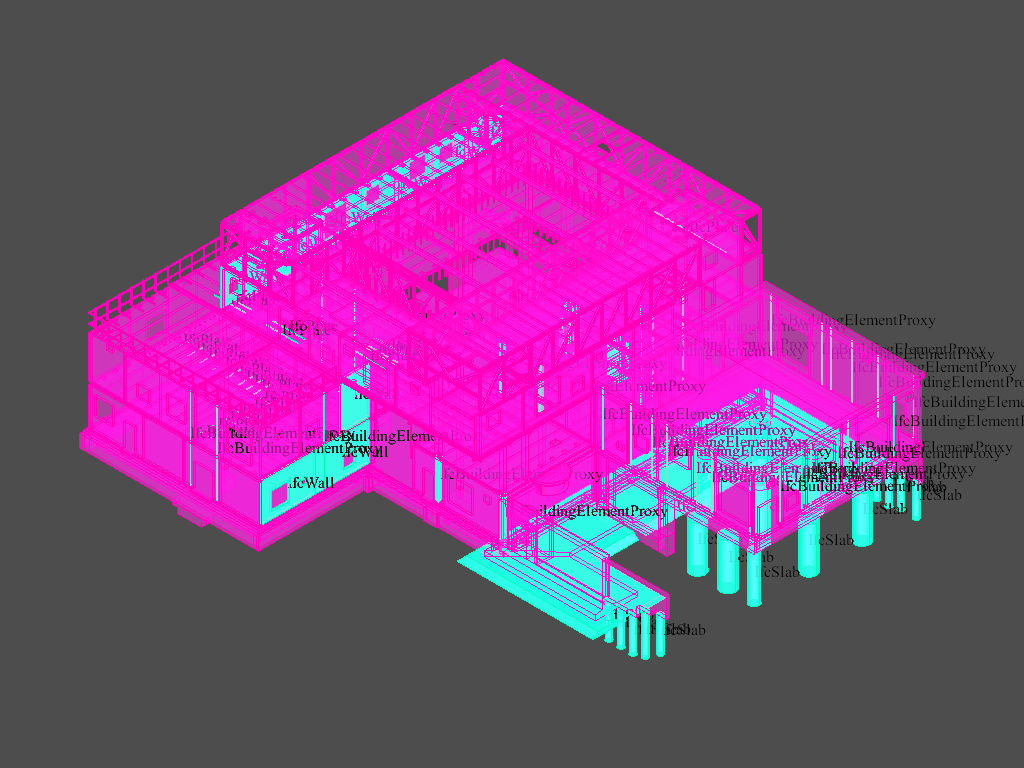

In [12]:
# RenderInWindow(NonLoadRenderFunc, GUIDS_load=elements_loadBearing, GUIDS_nonload=elements_nonloadBearing, modelData=modelData)
RenderImage(NonLoadRenderFunc, GUIDS_load=elements_loadBearing, GUIDS_nonload=elements_nonloadBearing, modelData=modelData)

In [13]:
from OCC.Core.gp import gp_Pnt

# create two points
p1 = gp_Pnt(0, 0, 0)
p2 = gp_Pnt(0.1, 0.1, 0.1)

# check if they are close together
if p1.Distance(p2) < 0.2:
    print("The points are close together.")
else:
    print("The points are far apart.")


The points are close together.


## Make analytical model

In [14]:
def LineRenderFunc(renderer, **args):
    """Render a bunch of shapes"""

    modelData = args['modelData']
    GUIDS = args['GUIDS']

    # transparency = 0.8
    # color = Quantity_Color(1.0, 0.0, 0.5, Quantity_TOC_RGB)
    # for i,  GUID in enumerate(GUIDS):
    #     to_update = i % 50 == 0

    #     try:
    #         keys = modelData.shapes[GUID].keys()
    #         if not keys == {'Body'}:
    #              continue
            
    #         shape = modelData.shapes[GUID]['Body'].geometry
    #         renderer.DisplayShape(
    #             shape,
    #             color=color,
    #             transparency=transparency,
    #             update=to_update,
    #         )

    #     except Exception as e:
    #             print(f"Error! {e}")

    shapeStat = dict()

    transparency = 0.2
    color = Quantity_Color(0.0, 1.0, 0.5, Quantity_TOC_RGB)
    for i, GUID in enumerate(GUIDS):
        to_update = i % 50 == 0

        #sorted
        key = tuple(modelData.shapes[GUID].keys())
        if not key in shapeStat:
             shapeStat[key] = 0
        
        shapeStat[key] += 1

        try:
            for key, shape in modelData.shapes[GUID].items():
                if key == 'Body': continue

                if key == 'Axis':
                    color = Quantity_Color(1.0, 0.0, 0.5, Quantity_TOC_RGB)
                if key == 'FootPrint':
                    color = Quantity_Color(0.0, 0.5, 1.0, Quantity_TOC_RGB)
                

                shape = modelData.shapes[GUID][key].geometry
                element = modelData.model.by_guid(GUID)

                renderer.DisplayShape(
                    shape,
                    color=color,
                    transparency=transparency,
                    update=to_update,
                )

        except Exception as e:
                print(f"Error! {e}")

    # Render class of non-load bearing elements
    color = Quantity_Color(0.0, 0.0, 0.0, Quantity_TOC_RGB)
    for i, GUID in enumerate(GUIDS):
        to_update = i % 50 == 0

        try:
            element = modelData.model.by_guid(GUID)

            obb = modelData.obbs[GUID]
            textLabel = AIS_TextLabel()
            textLabel.SetPosition(gp_Pnt(obb.Center()))
            textLabel.SetText(TCollection_ExtendedString(f"{element.is_a()}"))
            textLabel.SetColor(color)
            
            renderer.Context.Display(textLabel, False)

        except Exception as e:
                print(f"Error! {e}")

    print(shapeStat)

    renderer.FitAll()

In [15]:
# RenderInWindow(LineRenderFunc, GUIDS=elements, modelData=modelData)

In [16]:
counter = 0
for GUID in elements:
    keys = modelData.shapes[GUID].keys()
    if keys == {'Body'}:
        counter += 1

        # print(modelData.model.by_guid(GUID).get_info())

print(counter)

197


### Construct analytical model with Axis and FootPrint

In [17]:
class Knot3D:
    def __init__(self) -> None:
        pass

class StructuralMember:
    def __init__(self) -> None:
        pass

class Beam(StructuralMember):
    def __init__(self, axis) -> None:
        super().__init__()

        assert is_wire_straight_line(axis)
        self.axis = axis

class Column(StructuralMember):
    def __init__(self, axis) -> None:
        super().__init__()

        assert is_wire_straight_line(axis)
        self.axis = axis

class Slab(StructuralMember):
    def __init__(self) -> None:
        super().__init__()


**Initial line model based on provided Axis and FootPrint**:

In [18]:
importlib.reload(geomUtils)
from geomUtils import *

In [19]:
members = dict()

for GUID in elements:
    shapes = modelData.shapes[GUID]
    keys = shapes.keys()
    element = modelData.model.by_guid(GUID)

    assert 'Body' in keys
    
    # Assert that an element doesn't have both Axis and FootPrint
    assert not ('Axis' in keys and 'FootPrint' in keys)

    IfcClass = element.is_a()

    # Beam
    if IfcClass == 'IfcBeam':
        assert 'Axis' in keys

        axis = shapes['Axis'].geometry
        subShapes = get_subShapes(axis)
        assert len(subShapes) == 1
        
        shape = subShapes[0]
        assert is_wire_straight_line(shape)
        wire = shape

        member = Beam(wire)

        members[GUID] = member
        

    # Column
    elif IfcClass == 'IfcColumn':
        body = shapes['Body'].geometry
        obb = modelData.obbs[GUID]

        wire = convert_bnd_to_line(obb, returnWire=True)

        member = Column(wire)
        members[GUID] = member

    # Slab
    elif IfcClass == 'IfcSlab':
        # assert 'FootPrint' in keys
        if not 'FootPrint' in keys:
            slab = element
            obb = modelData.obbs[GUID]
            break

    # Wall
    elif IfcClass == 'IfcWall':
        pass

    # Plate
    elif IfcClass == 'IfcPlate':
        pass

    else:
        print(f"Unknown class: {IfcClass}")


In [20]:
slab = modelData.model.by_type('IfcWall')[19]

In [21]:
slab

#2607=IfcWall('10_xNELsT8vhbJuYV3N6Jb',#18,'Basic Wall:VE20-0:696702',$,'Basic Wall:VE20-0',#2576,#2606,'696702',.NOTDEFINED.)

In [22]:
body = modelData.shapes[slab.GlobalId]['Body'].geometry
obb = modelData.obbs[slab.GlobalId]

body

<class 'TopoDS_Compound'>

In [23]:
subShapes = get_subShapes(body)
subShapes

[<class 'TopoDS_Compound'>]

In [24]:
solid = subShapes[0]

**Ide**: Tag slabs OBB, find den korteste akse for at danne plans retning.
Scale solid til at være meget tynd

Juster koordinator til alle at ligge i planet. Lav union region af faces

In [25]:
from OCC.Core.gp import gp_Pln
from OCC.Core.gp import gp_Ax3

def convert_bnd_to_pane(the_box):
    """Converts a bounding box to a plane."""
    barycenter = the_box.Center()
    x_dir = the_box.XDirection()
    y_dir = the_box.YDirection()
    z_dir = the_box.ZDirection()
    half_x = the_box.XHSize()
    half_y = the_box.YHSize()
    half_z = the_box.ZHSize()

    half_sizes = np.array([half_x, half_y, half_z])
    maxIndex = np.argmax(half_sizes)
    minIndex = np.argmin(half_sizes)
    middleIndex = 3 - maxIndex - minIndex
    
    x_vec = gp_XYZ(x_dir.X(), x_dir.Y(), x_dir.Z())
    y_vec = gp_XYZ(y_dir.X(), y_dir.Y(), y_dir.Z())
    z_vec = gp_XYZ(z_dir.X(), z_dir.Y(), z_dir.Z())

    vecs = np.array([x_vec, y_vec, z_vec])
    dirs = np.array([x_dir, y_dir, z_dir])

    point = gp_Pnt(barycenter.X(), barycenter.Y(), barycenter.Z())


    axes = gp_Ax2(point, gp_Dir(dirs[minIndex]), gp_Dir(dirs[middleIndex]))
    # axes = gp_Ax2(point, gp_Dir(dirs[maxIndex]), gp_Dir(dirs[middleIndex]))
    # axes.SetLocation(
    #     gp_Pnt(point.XYZ() - x_vec * half_x - y_vec * half_y - z_vec * half_z)
    # )
    
    axes = gp_Ax3(axes)

    print(axes)

    plane = gp_Pln(axes)

    x_dir = gp_Dir(x_dir)
    y_dir = gp_Dir(y_dir)
    z_dir = gp_Dir(z_dir)

    return plane, axes, z_dir

plane, axes, z_dir = convert_bnd_to_pane(obb)
plane

<class 'gp_Ax3'>


<class 'gp_Pln'>

In [26]:
from OCC.Core.GeomAPI import GeomAPI_ProjectPointOnCurve
from OCC.Core.GeomProjLib import geomprojlib_ProjectOnPlane
from OCC.Core.BRepProj import BRepProj_Projection
from OCC.Core.ProjLib import  ProjLib_ProjectOnPlane, ProjLib_ProjectOnSurface

import OCC.Core.BRepProj
import OCC.Core.gp
import OCC.Core.TopoDS
import OCC.Core.BRepBuilderAPI
import OCC.Core.BRepPrimAPI
import OCC.Core.BRepAlgoAPI
import OCC.Core.BRepMesh

from OCC.Core.BRepAlgo import BRepAlgo_NormalProjection
from OCC.Core.BRepBuilderAPI import BRepBuilderAPI_MakeShape

# create a box
# box = OCC.Core.BRepPrimAPI.BRepPrimAPI_MakeBox(10, 20, 30).Shape()

# create a plane
# plane = 
# plane = OCC.Core.BRepBuilderAPI.BRepBuilderAPI_MakeFace(OCC.Core.gp.gp_Pln(OCC.Core.gp.gp_Ax3(), 0, 0, 1)).Face()
# plane = planeface

# planeface = OCC.Core.BRepBuilderAPI.BRepBuilderAPI_MakeFace(plane).Face()
planeface = OCC.Core.BRepBuilderAPI.BRepBuilderAPI_MakeFace(plane).Shape()
# BRepBuilderAPI_MakeShape.Build()


# project the box onto the plane
proj = BRepAlgo_NormalProjection(planeface)
proj.Init(planeface)
proj.Add(solid)
# proj.Add(plane)

proj.Build()
print("Is done", proj.IsDone())

projSurf = proj.Projection()

# proj = OCC.Core.BRepProj.BRepProj_Projection(solid, plane, z_dir)
# OCC.Core.BRepProj.BRepProj_Projection()

# create a surface from the projected shape
surface = OCC.Core.BRepAlgoAPI.BRepAlgoAPI_Section(projSurf, planeface).Shape()

# mesh the surface
mesh = BRepMesh_IncrementalMesh(surface, 0.01)
mesh.Perform()
print(mesh.IsDone())


Is done True
True


In [27]:
from OCC.Extend.ShapeFactory import point_list_to_TColgp_Array1OfPnt, make_face
from OCC.Core.GeomFill import (
    GeomFill_BSplineCurves,
    GeomFill_StretchStyle,
    GeomFill_CoonsStyle,
    GeomFill_CurvedStyle,
    geomfill_Surface,
)

In [28]:
get_subShapes(mesh.Shape())

[<class 'TopoDS_Edge'>,
 <class 'TopoDS_Edge'>,
 <class 'TopoDS_Edge'>,
 <class 'TopoDS_Edge'>,
 <class 'TopoDS_Edge'>,
 <class 'TopoDS_Edge'>,
 <class 'TopoDS_Edge'>,
 <class 'TopoDS_Edge'>,
 <class 'TopoDS_Edge'>,
 <class 'TopoDS_Edge'>,
 <class 'TopoDS_Edge'>,
 <class 'TopoDS_Edge'>,
 <class 'TopoDS_Edge'>,
 <class 'TopoDS_Edge'>,
 <class 'TopoDS_Edge'>,
 <class 'TopoDS_Edge'>,
 <class 'TopoDS_Edge'>,
 <class 'TopoDS_Edge'>,
 <class 'TopoDS_Edge'>,
 <class 'TopoDS_Edge'>,
 <class 'TopoDS_Edge'>,
 <class 'TopoDS_Edge'>,
 <class 'TopoDS_Edge'>,
 <class 'TopoDS_Edge'>,
 <class 'TopoDS_Edge'>,
 <class 'TopoDS_Edge'>,
 <class 'TopoDS_Edge'>,
 <class 'TopoDS_Edge'>,
 <class 'TopoDS_Edge'>,
 <class 'TopoDS_Edge'>,
 <class 'TopoDS_Edge'>,
 <class 'TopoDS_Edge'>,
 <class 'TopoDS_Edge'>,
 <class 'TopoDS_Edge'>,
 <class 'TopoDS_Edge'>,
 <class 'TopoDS_Edge'>,
 <class 'TopoDS_Edge'>,
 <class 'TopoDS_Edge'>,
 <class 'TopoDS_Edge'>,
 <class 'TopoDS_Edge'>,
 <class 'TopoDS_Edge'>,
 <class 'TopoDS_

In [29]:
from OCC.Core.Geom import Geom_Plane
from OCC.Core.Aspect import Aspect_GT_Rectangular
from OCC.Core.Aspect import Aspect_GDM_Lines

def SimpleRenderFunc2(renderer, **args):
    """Render a bunch of shapes"""

    shapes = args['shapes']
    solids = args['solids']

    for i, shape in enumerate(solids):
        to_update = i % 50 == 0

        try:
            renderer.DisplayShape(
                shape,
                update=to_update,
                transparency=0.95,
            )

        except Exception as e:
                print(f"Error! {e}")
                
    for i, shape in enumerate(shapes):
        to_update = i % 50 == 0

        try:
            renderer.DisplayShape(
                shape,
                update=to_update,
            )

        except Exception as e:
                print(f"Error! {e}")

    try:
        pass
        # create a plane
        # plane = gp_Pln(gp_Ax3(gp_Pnt(0, 0, 0), gp_Dir(0, 0, 1)))

        # display the plane
        # renderer.Viewer.display(plane, update=True)

        # renderer.Context.display_plane(plane, update=True)
        # planeface = OCC.Core.BRepBuilderAPI.BRepBuilderAPI_MakeFace(plane)
        # planeface.Build()
        # print("IsDone", planeface.IsDone())

        # # renderer.Context.Display(plane, False)


        # face = planeface.Face()
        # print(face)
        # subShapes = get_subShapes(face)
        # print(subShapes)

        # renderer.Viewer.SetPrivilegedPlane(axes)
        # renderer.Viewer.ActivateGrid(Aspect_GT_Rectangular, Aspect_GDM_Lines);

        # renderer.DisplayShape(
        #     planeface.Face(),
        #     update=True,
        #     # transparency=0.95,
        # )

        # geom_plane = Geom_Plane(plane)
        # ais_plane = AIS_Plane(geom_plane, False)
        # renderer.Context.Display(ais_plane, True)

        
    except Exception as e:
            print(f"Error! {e}")



    renderer.FitAll()

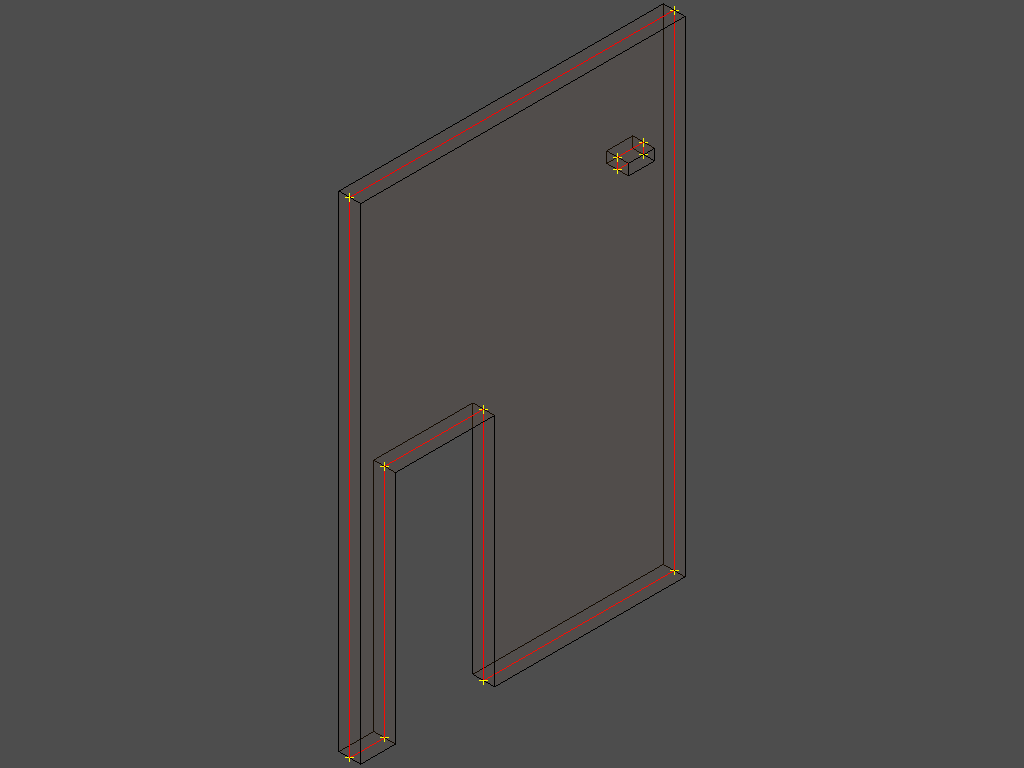

In [30]:
#RenderInWindow(SimpleRenderFunc2, shapes=[mesh.Shape()], solids=[solid])
RenderImage(SimpleRenderFunc2, shapes=[mesh.Shape()], solids=[solid])

In [31]:
mesh.Perform()

In [32]:
mesh

<class 'BRepMesh_IncrementalMesh'>

In [33]:
get_subShapes(projSurf)

[<class 'TopoDS_Edge'>,
 <class 'TopoDS_Edge'>,
 <class 'TopoDS_Edge'>,
 <class 'TopoDS_Edge'>,
 <class 'TopoDS_Edge'>,
 <class 'TopoDS_Edge'>,
 <class 'TopoDS_Edge'>,
 <class 'TopoDS_Edge'>,
 <class 'TopoDS_Edge'>,
 <class 'TopoDS_Edge'>,
 <class 'TopoDS_Edge'>,
 <class 'TopoDS_Edge'>,
 <class 'TopoDS_Edge'>,
 <class 'TopoDS_Edge'>,
 <class 'TopoDS_Edge'>,
 <class 'TopoDS_Edge'>,
 <class 'TopoDS_Edge'>,
 <class 'TopoDS_Edge'>,
 <class 'TopoDS_Edge'>,
 <class 'TopoDS_Edge'>,
 <class 'TopoDS_Edge'>,
 <class 'TopoDS_Edge'>,
 <class 'TopoDS_Edge'>,
 <class 'TopoDS_Edge'>,
 <class 'TopoDS_Edge'>,
 <class 'TopoDS_Edge'>,
 <class 'TopoDS_Edge'>,
 <class 'TopoDS_Edge'>,
 <class 'TopoDS_Edge'>,
 <class 'TopoDS_Edge'>,
 <class 'TopoDS_Edge'>,
 <class 'TopoDS_Edge'>,
 <class 'TopoDS_Edge'>,
 <class 'TopoDS_Edge'>,
 <class 'TopoDS_Edge'>,
 <class 'TopoDS_Edge'>,
 <class 'TopoDS_Edge'>,
 <class 'TopoDS_Edge'>,
 <class 'TopoDS_Edge'>,
 <class 'TopoDS_Edge'>,
 <class 'TopoDS_Edge'>,
 <class 'TopoDS_

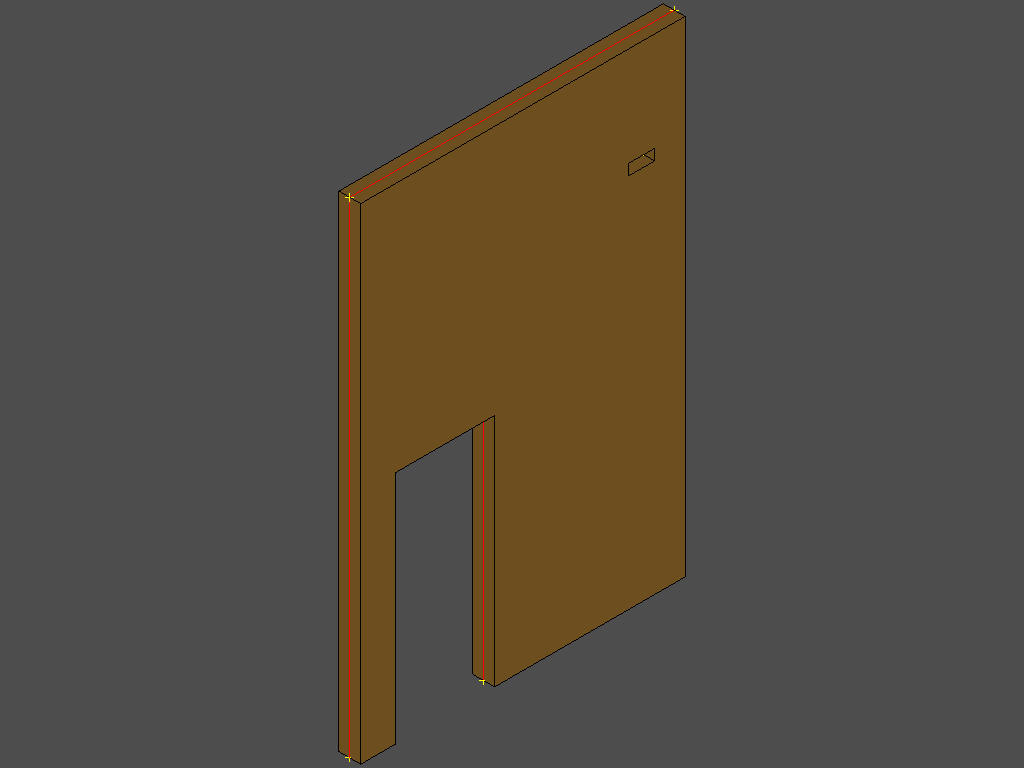

In [34]:
# RenderInWindow(SimpleRenderFunc, shapes=[projSurf, solid])
RenderImage(SimpleRenderFunc, shapes=[projSurf, solid])

**Render structural members**:

In [35]:
def RenderStructuralMembersFunc(renderer, **args):
    modelData = args['modelData']
    members = args['members']

    RED = Quantity_Color(1.0, 0.0, 0.0, Quantity_TOC_RGB)
    GREEN = Quantity_Color(0.0, 1.0, 0.0, Quantity_TOC_RGB)
    BLUE = Quantity_Color(0.0, 0.0, 1.0, Quantity_TOC_RGB)
    MAGENTA = Quantity_Color(1.0, 0.0, 1.0, Quantity_TOC_RGB)


    # Idea: have render code be part of each Structural Members own class
    transparency = 0.8
    color = Quantity_Color(1.0, 0.0, 0.5, Quantity_TOC_RGB)
    for i,  (GUID, member) in enumerate(members.items()):
        to_update = i % 50 == 0

        try:
            # print(type(member))
            if type(member) == Beam:

                # Render axis
                axis = member.axis
                
                shape = axis
                renderer.DisplayShape(
                    shape,
                    color=color,
                    transparency=transparency,
                    update=to_update,
                )

                # Render points
                wire = shape

                p1, p2 = geomUtils.get_wire_endpoints(wire)

                renderer.DisplayShape(
                    p1,
                    # color=color,
                )
                renderer.DisplayShape(
                    p2,
                    # color=color,
                )

                # Render label
                obb = modelData.obbs[GUID]
                textLabel = AIS_TextLabel()
                textLabel.SetPosition(gp_Pnt(obb.Center()))
                textLabel.SetText(TCollection_ExtendedString(f"Beam"))
                textLabel.SetColor(color)

                renderer.Context.Display(textLabel, False)

            if type(member) == Column:
                wire = member.axis

                # Render axis
                shape = wire
                renderer.DisplayShape(
                    shape,
                    color=Quantity_Color(0.0, 1.0, 0.5, Quantity_TOC_RGB),
                    transparency=transparency,
                    update=to_update,
                )

                # Render points
                p1, p2 = geomUtils.get_wire_endpoints(wire)

                renderer.DisplayShape(
                    p1,
                    color=BLUE,
                )
                renderer.DisplayShape(
                    p2,
                    color=BLUE,
                )

                # Render label
                obb = modelData.obbs[GUID]
                textLabel = AIS_TextLabel()
                textLabel.SetPosition(gp_Pnt(obb.Center()))
                textLabel.SetText(TCollection_ExtendedString(f"Column"))
                textLabel.SetColor(color)

                renderer.Context.Display(textLabel, False)

        except Exception as e:
                print(f"Error! {e}")
                

    renderer.FitAll()

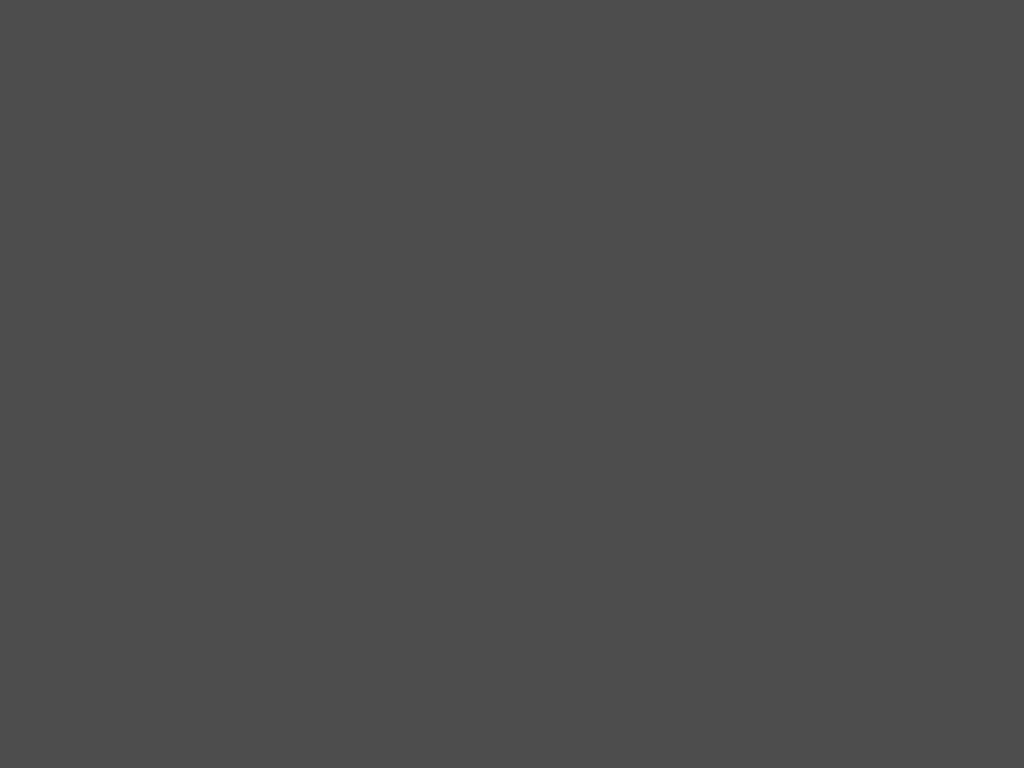

In [36]:
# RenderInWindow(RenderStructuralMembersFunc, modelData=modelData, members=members)
RenderImage(RenderStructuralMembersFunc, modelData=modelData, members=members)


**Ide**: Lav både en helt simpel FEM-model hvor alle elementer har deres oprindelige knuder, og er forbundet med meget stive linjer, og en FEM-model hvor knuder i højere grad forsøges at blive merget.

## New collision test

In [37]:
# elements = list(ifcopenshell.util.selector.filter_elements(model,
    # "IfcBeam + IfcColumn, /Pset_.*Common/.LoadBearing=TRUE"))

elements = list(ifcopenshell.util.selector.filter_elements(model,
    "IfcBuildingElement, /Pset_.*Common/.LoadBearing=TRUE"))

elements = {element.GlobalId: element for element in elements}
# elements_shape = {GUID: modelData.shapes[GUID]['Body'] for GUID in elements.keys()}

# elements_obb = get_elementsOBB(elements_shape)
obbs = modelData.obbs
print(len(obbs))
obbs = {GUID: obbs[GUID] for GUID in elements.keys()}
print(len(obbs))
common_collisions, element_collisions = find_collisions(obbs)

1963
1750


In [38]:
collision_pairs = set()

alreadyFound = 0
i = 0
for GUID, collisions in element_collisions.items():
    # if len(collisions) == 0:
    #     print(f"{GUID} has zero collisions!")
    # if i > 20: break
    for OTHER_GUID in collisions:
        if GUID == OTHER_GUID:
            print("!!!!!!!!!!")
        i +=1
        
        col_pair = tuple(sorted([GUID, OTHER_GUID]))
        if col_pair in collision_pairs:
            alreadyFound += 1
        collision_pairs.add(col_pair)

# print(alreadyFound)
# print(i)
# len(collision_pairs)

In [39]:
obb_pairs = dict()

for col_pair in collision_pairs:
    GUID1, GUID2 = col_pair
    shp1 = modelData.shapes[GUID1]['Body']
    shp2 = modelData.shapes[GUID2]['Body']

    obb1 = get_OBB(shp1.geometry)
    obb2 = get_OBB(shp2.geometry)
    
    addF = 0.01
    mulF = 1.0
    elongatedObb1 = elongateOBB(obb1, mulF, addF)
    elongatedObb2 = elongateOBB(obb2, mulF, addF)
    
    elongatedObb1.Enlarge(0.002)
    elongatedObb2.Enlarge(0.002)

    obb_pairs[col_pair] = (elongatedObb1, elongatedObb2)
    

In [40]:
intersection_obbs = dict()

for col_pair, (obb1, obb2) in obb_pairs.items():
    b1 = convert_bnd_to_shape(obb1)
    b2 = convert_bnd_to_shape(obb2)
    solidIntersection = BRepAlgoAPI_Common(b1, b2).Shape()

    intersection_obbs[col_pair] = solidIntersection
    

In [41]:
len(obb_pairs)

4883

In [42]:
GUIDS_single = set({
    *[GUID1 for (GUID1, GUID2) in obb_pairs.keys()],
    *[GUID2 for (GUID1, GUID2) in obb_pairs.keys()],
})
len(GUIDS_single)

1745

In [43]:
class Knot:
    def __init__(self, point: gp_Pnt, OBB: Bnd_OBB) -> None:
        self.point = point
        self.OBB = OBB
        self.columnDefined = None
        self.info = ""
        self.color = Quantity_Color(1.0, 0.0, 0.5, Quantity_TOC_RGB)

    def __str__(self) -> str:
        X = self.point.X()
        Y = self.point.Y()
        Z = self.point.Z()

        return f"Knot at ({X} {Y} {Z}). ColumnDefined: {self.columnDefined}"

    def makeColumnDefined(self, guids: set) -> None:
        self.columnDefined = True
        self.columnGuids = guids

    def setOriginInfo(self, info: str) -> None:
        self.info = info
    
    def setColor(self, color: Quantity_Color) -> None:
        self.color = color


In [44]:
def findColumnKnots(intersection_obbs):
    
    columnKnots = dict()

    for col_pair, solidIntersection in intersection_obbs.items():
        GUID1, GUID2 = col_pair

        # Check if both GUIDs refer to a column
        if False in [elements[GUID].is_a('IfcColumn') for GUID in [GUID1, GUID2]]:
            continue

        obb = get_OBB(solidIntersection)
        pnt = gp_Pnt(obb.Center())

        knot = Knot(pnt, obb)
        knot.makeColumnDefined(col_pair)
        knot.setColor(Quantity_Color(1.0, 0.0, 0.0, Quantity_TOC_RGB))

        columnKnots[col_pair] = knot

    return columnKnots

In [45]:
columnKnots = findColumnKnots(intersection_obbs)
len(columnKnots)

97

In [46]:
list(columnKnots)[5]

('1z9uceUfrApQ_nV$si6y7L', '1z9uceUfrApQ_nV$wi6y7L')

In [47]:
def findWeakColumnKnots(intersection_obbs, columnKnots):
    weakKnots = dict()
    global specialIntersections
    specialIntersections = dict()
    for col_pair, solidIntersection in intersection_obbs.items():
        if col_pair in columnKnots:
            # print("Already defined")
            continue

        GUID1, GUID2 = col_pair

        # Check if one or more GUIDS refer to IfcColum
        if not True in [elements[GUID].is_a('IfcColumn') for GUID in [GUID1, GUID2]]:
            continue
        
        if elements[GUID1].is_a('IfcColumn'):
            COL_GUID = GUID1
            OTHER_GUID = GUID2
        else:
            COL_GUID = GUID2
            OTHER_GUID = GUID1

        column_obb = modelData.obbs[COL_GUID]
        other_obb = modelData.obbs[OTHER_GUID]

        addF = 10.0
        mulF = 1.0
        elongatedObb = elongateOBB(column_obb, mulF, addF)
        elongatedObb.Enlarge(0.01)

        b1 = convert_bnd_to_shape(elongatedObb)
        b2 = convert_bnd_to_shape(other_obb)
        solidIntersection = BRepAlgoAPI_Common(b1, b2).Shape()

        obb = get_OBB(solidIntersection)
        # print(obb.SquareExtent())
        # print(obb.XHSize(), obb.YHSize(), obb.ZHSize())
        if obb.ZHSize() <= 0:
            specialIntersections[col_pair] = solidIntersection
            continue
        
        
        pnt = gp_Pnt(obb.Center())

        knot = Knot(pnt, obb)
        knot.makeColumnDefined(col_pair)
        # knot.setColor(Quantity_Color(0.0, 1.0, 0.0, Quantity_TOC_RGB))

        weakKnots[col_pair] = knot

    if len(specialIntersections) > 0:
        print("Warning! Special intersections")
        
    return weakKnots

In [48]:
weakKnots = findWeakColumnKnots(intersection_obbs, columnKnots)
len(weakKnots)

843

In [49]:
len(specialIntersections)

0

In [50]:
obbs = {key: knot.OBB for key, knot in weakKnots.items()}
common_collisions, element_collisions = find_collisions(obbs)

In [51]:
list(element_collisions.items())[10]

(('0GbdI8LmT7OudkFj2hwgDY', '1aEOgM_rL7hQ$$S3UgBVES'),
 [('1aEOgM_rL7hQ$$S3UgBVES', '3iqqCb9nXF_v6raZvUBQr5')])

In [52]:
len(common_collisions)

595

In [53]:
test123 = list(common_collisions)[23]
test123

(('0tLwwV0vjC7g9CAWp89ybI', '1fdNgs4QH1PuqYzxfYQ_TN'),
 ('124Hs1ZlrEkOJUpnF4xThh', '2Bbtc4Qtb4v9USChXqpWRZ'),
 ('1b$fKwqQf10OfRxX_oWs$s', '1fdNgs4QH1PuqYzxfYQ_TN'),
 ('1fdNgs4QH1PuqYzxfYQ_TN', '2aACP4ZNb0ZPt1wr0Sc57g'))

In [54]:
list(common_collisions)[23]

(('0tLwwV0vjC7g9CAWp89ybI', '1fdNgs4QH1PuqYzxfYQ_TN'),
 ('124Hs1ZlrEkOJUpnF4xThh', '2Bbtc4Qtb4v9USChXqpWRZ'),
 ('1b$fKwqQf10OfRxX_oWs$s', '1fdNgs4QH1PuqYzxfYQ_TN'),
 ('1fdNgs4QH1PuqYzxfYQ_TN', '2aACP4ZNb0ZPt1wr0Sc57g'))

In [55]:
allKnots = columnKnots | weakKnots

In [56]:
new_obbs = list()
for col_set in common_collisions:
    #print(len(col_set))
    obb = Bnd_OBB()
    for key in col_set:
        knot = allKnots[key]
        obb.Add(knot.OBB)
    
    new_obbs.append(obb)

print(len(new_obbs))


595


Done...


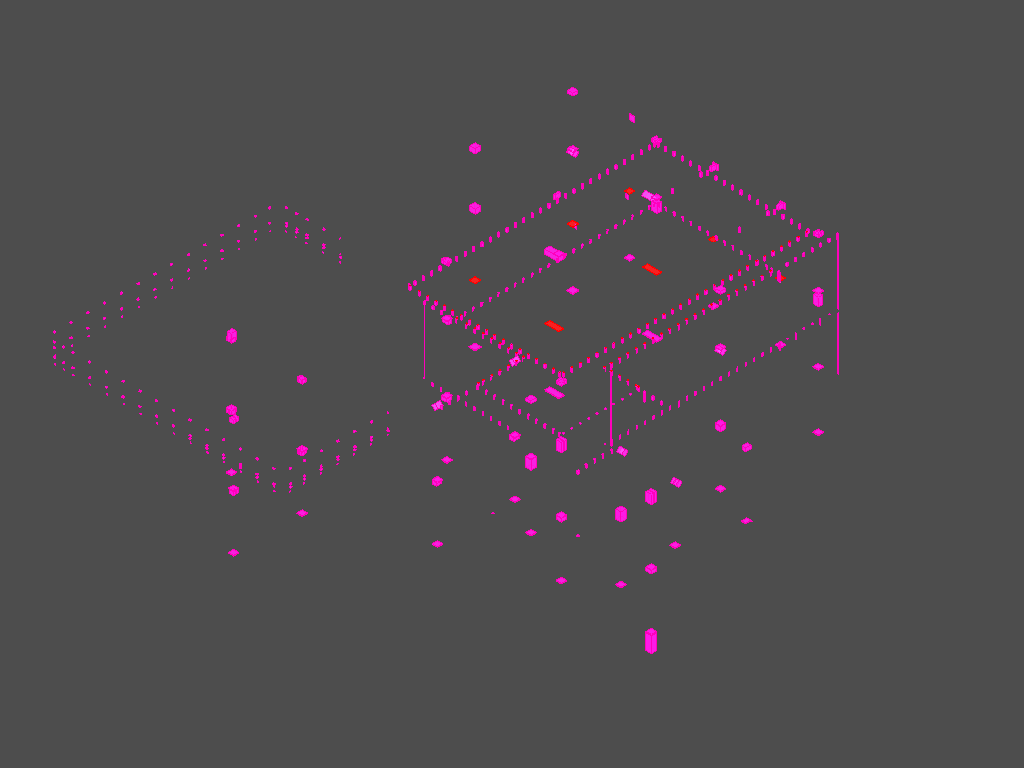

In [57]:
def renderColumnKnots(renderer, **args):
    for key, knot in (columnKnots | weakKnots).items():
        obb_shp = convert_bnd_to_shape(knot.OBB)

        color = knot.color

        ais = renderer.DisplayShape(
            obb_shp,
            transparency=0.3,
            color = color,
        )


    renderer.FitAll()
    print("Done...")

# RenderInWindow(renderColumnKnots)
RenderImage(renderColumnKnots)

Done...
Done...


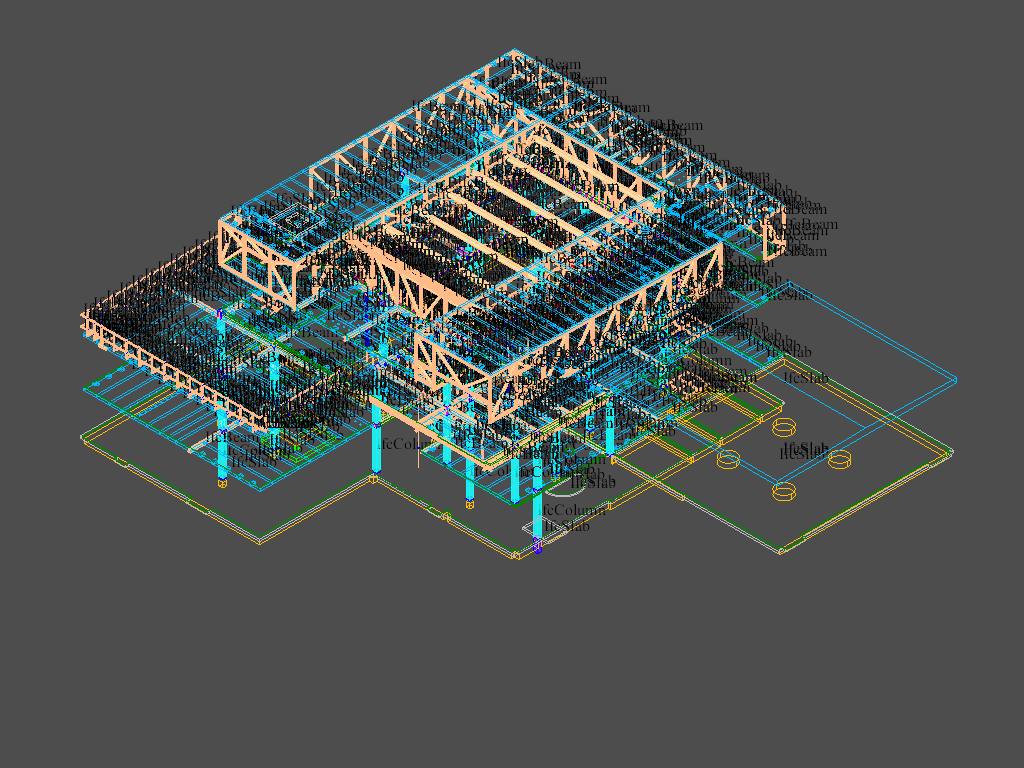

In [58]:
def renderColPairs(renderer, **args):
    global some_obbs
    global GUIDS_single
    global new_obbs


    renderColumnKnots(renderer)

    for key, intersecion in specialIntersections.items():
        renderer.DisplayShape(
            intersecion,
            # color = color,
            # transparency=transparency,
            # update=to_update,
        )

    for obb in new_obbs:
        obb_shp = convert_bnd_to_shape(obb)

        color = Quantity_Color(0.0, 0.0, 1.0, Quantity_TOC_RGB)

        ais = renderer.DisplayShape(
            obb_shp,
            transparency=0.3,
            color = color,
        )


    # for obb in some_obbs:
    #     obb_shp = convert_bnd_to_shape(obb)

    #     renderer.DisplayShape(
    #         obb_shp,
    #     )


    # for col_pair, (obb1, obb2) in obb_pairs.items():
    #     try:
    #         b1 = convert_bnd_to_shape(obb1)
    #         b2 = convert_bnd_to_shape(obb2)

    #         color = Quantity_Color(1.0, 0.5, 0.5, Quantity_TOC_RGB)
    #         renderer.DisplayShape(
    #             [b1, b2],
    #             transparency=0.7,
    #             color = color,
    #         )

    #     except Exception as e:
    #         print(e)


    # for col_pair, solidIntersection in intersection_obbs.items():
    #     color = Quantity_Color(1.0, 0.0, 1.0, Quantity_TOC_RGB)
    #     GUID1, GUID2 = col_pair

    #     # Check if one or more GUIDS refer to IfcColum
    #     if not True in [elements[GUID].is_a('IfcColumn') for GUID in [GUID1, GUID2]]:
    #         continue

    #     ais = renderer.DisplayShape(
    #         solidIntersection,
    #         transparency=0.3,
    #         color = color,
    #     )


    for GUID in GUIDS_single:
        pdct_shape = modelData.shapes[GUID]['Body']

        r,g,b,alpha = pdct_shape.styles[0] # the shape color
        color = Quantity_Color(abs(r), abs(g), abs(b), Quantity_TOC_RGB)

        transparency = abs(1 - alpha)

        transparency = 0.5
        if (not elements[GUID].is_a('IfcColumn')
            and not elements[GUID].is_a('IfcSlab')
            and not elements[GUID].is_a('IfcBeam')):
            transparency = 1.0
            continue
        if elements[GUID].is_a('IfcSlab'):
            transparency = 1.0


        renderer.DisplayShape(
            pdct_shape.geometry,
            color = color,
            transparency=transparency,
            # update=to_update,
        )

        obb = modelData.obbs[GUID]
        textLabel = AIS_TextLabel()
        textLabel.SetPosition(gp_Pnt(obb.Center()))
        # textLabel.SetText(TCollection_ExtendedString(f"{GUID}"))
        textLabel.SetText(TCollection_ExtendedString(f"{elements[GUID].is_a()}"))
        color = Quantity_Color(0.0, 0.0, 0.0, Quantity_TOC_RGB)
        textLabel.SetColor(color)
        
        renderer.Context.Display(textLabel, False)




    renderer.FitAll()
    print("Done...")

# RenderInWindow(renderColPairs)
RenderImage(renderColPairs)

## Tests

In [59]:
wall = model.by_type('IfcWall')[200]
wall

#32341=IfcWall('1s4iAtHXv8f89265OVfcKx',#18,'Basic Wall:VE20-0:2203117',$,'Basic Wall:VE20-0',#32308,#32340,'2203117',.NOTDEFINED.)

In [60]:
# data = modelData.shapes['1s4iAtHXv8f89265OVfcKx']['Body']
# data

In [61]:
settings = ifcopenshell.geom.settings()
shape = ifcopenshell.geom.create_shape(settings, wall)

In [62]:
materials = shape.geometry.materials
material_ids = shape.geometry.material_ids
for mat in materials:
    print(mat.name)
    print(mat.original_name())

print(material_ids)

surface-style-325-4.-(ve)-v--gelement
4. (VE) Vægelement
(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)


In [63]:
model.by_type('IfcMaterial')

[#182=IfcMaterial('5. (DE) Dækelement',$,'Materials'),
 #286=IfcMaterial('3. (DK) Terrændæk',$,'Materials'),
 #330=IfcMaterial('4. (VE) Vægelement',$,'Materials'),
 #702=IfcMaterial('4. (SE) Elementsøjle',$,'Materials'),
 #706=IfcMaterial('@_DE_Beton Element',$,'Materials'),
 #3376=IfcMaterial('4. (SB) Stålbjælke',$,'Materials'),
 #5369=IfcMaterial('2. (FS) Liniefundament',$,'Materials'),
 #5941=IfcMaterial('2. (FPB) Brøndfundament',$,'Materials'),
 #6528=IfcMaterial('2. (FSS) Fundamentssokkel, stribe',$,'Materials'),
 #6619=IfcMaterial('4. (VG) Vægge, pladsstøbt',$,'Materials'),
 #7923=IfcMaterial('2. (FP) Punktfundament',$,'Materials'),
 #8008=IfcMaterial('2. (FSP) Fundamentssokkel, punkt',$,'Materials'),
 #8357=IfcMaterial('@_IH_Isolering Hård',$,'Materials'),
 #8583=IfcMaterial('2. (FSG) Liniefundament, grovbeton',$,'Materials'),
 #10125=IfcMaterial('5. (DK) Pladsstøbte dæk',$,'Materials'),
 #11719=IfcMaterial('2.(FLP) Pladefundament',$,'Materials'),
 #26593=IfcMaterial('4. (SB) St

In [64]:
def displayAllFunc(renderer, **args):
    data = args['data']

    # global viewer
    viewer = renderer.Viewer
    viewer.Erase()

    layerIndices = TColStd_SequenceOfInteger()
    viewer.GetAllZLayers(layerIndices)
    for i in range(1, layerIndices.Size() + 1):
        didDelete = viewer.RemoveZLayer(layerIndices.Value(i))
        if didDelete: print("Deleted one!")

    # #create 2 layers with different settings
    # settings_1 = Graphic3d_ZLayerSettings()
    # layer_created_1, layer_id_1 = viewer.AddZLayer(settings_1)
    # if layer_created_1:
    #     print("Layer 1 successfully created")
    #     print("Layer 1 id:", layer_id_1)

    # settings_2 = Graphic3d_ZLayerSettings()
    # layer_created_2, layer_id_2 = viewer.AddZLayer(settings_2)
    # if layer_created_1:
    #     print("Layer 2 successfully created")
    #     print("Layer 2 id:", layer_id_2)

    for i, (GUID, shape) in enumerate(data.items()):
        to_update = i % 50 == 0
        if shape.get('Body') and True:
            pdct_shape = shape['Body']

            if pdct_shape.data.type in ['IfcBeam']:
                transparency = 0.1
            else:
                transparency = 0.9

            r,g,b,alpha = pdct_shape.styles[0] # the shape color
            color = Quantity_Color(abs(r), abs(g), abs(b), Quantity_TOC_RGB)

            renderer.DisplayShape(
                pdct_shape.geometry,
                color = color,
                # transparency=abs(1 - alpha),
                transparency=transparency,
                update=to_update,
            )
        
        if shape.get('Axis') and True:
            pdct_shape = shape['Axis']

            [ais] = renderer.DisplayShape(pdct_shape.geometry)
            width = float(15.0)
            ais.SetWidth(width)
            # ais.SetZLayer(layer_id_1)

        if shape.get('FootPrint') and True:
            pdct_shape = shape['FootPrint']

            color = Quantity_Color(1.0, 0.0, 1.0, Quantity_TOC_RGB)

            renderer.DisplayShape(
                pdct_shape.geometry,
                color=color,
            )

    renderer.Viewer.DisplayPrivilegedPlane(True, 100.0)
    renderer.FitAll()
    print("Done...")

Done...


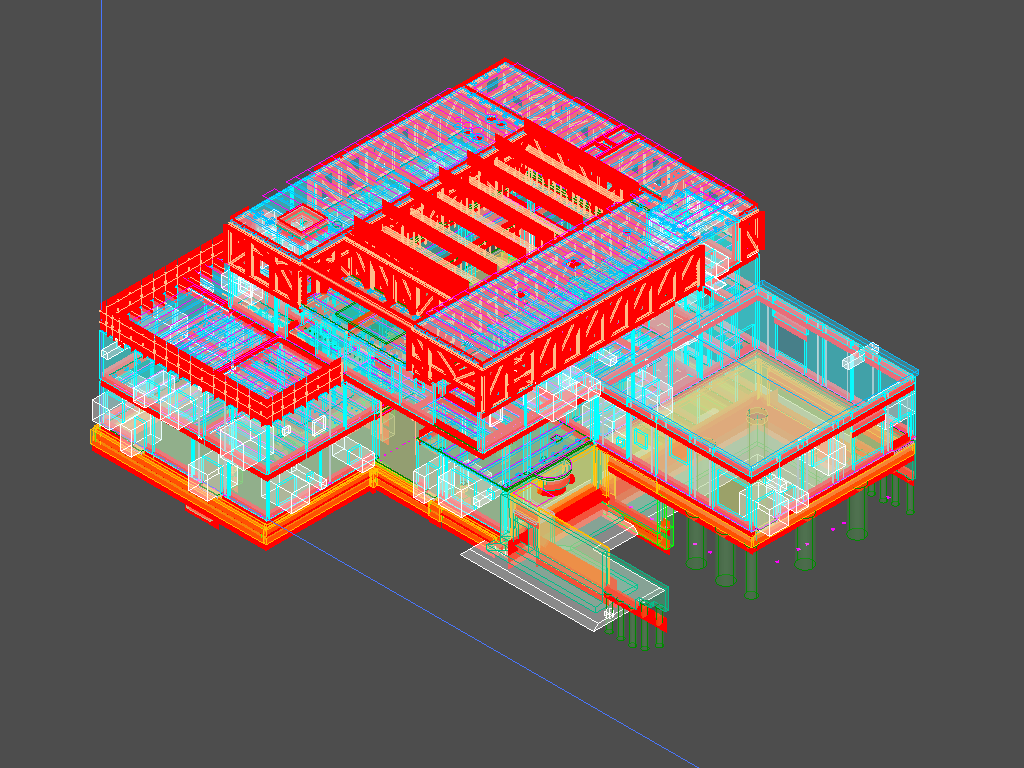

In [65]:
# RenderInWindow(displayAllFunc, data=modelData.shapes)
RenderImage(displayAllFunc, data=modelData.shapes)

### Load bearing elements

In [66]:
load_bearing = getLoadBearing(model)
load_bearing = {elm.GlobalId: elm for elm in load_bearing}
len(load_bearing)

Number of load-bearing elements: 1750
Unique types of loadbearing elements:
 {'IfcColumn', 'IfcSlab', 'IfcBeam', 'IfcWall'}


1750

In [67]:
loadBearing_shapeData = {GUID: modelData.shapes[GUID] for GUID in load_bearing.keys()}
len(loadBearing_shapeData)

1750

## Get IfcBeams as lines

In [68]:
bearingElements = dict()
for GUID, elm in load_bearing.items():
    key = elm.is_a()
    if not key in bearingElements:
        bearingElements[key] = list()
    
    bearingElements[key].append(elm)

[f"{key}: {len(val)}" for key, val in bearingElements.items()]

['IfcSlab: 365', 'IfcWall: 368', 'IfcColumn: 452', 'IfcBeam: 565']

In [69]:
beams = bearingElements['IfcBeam']
columns = bearingElements['IfcColumn']
slabs = bearingElements['IfcSlab']
walls = bearingElements['IfcWall']
elements = [*beams, *columns, *slabs, *walls]
elementsColWalls = [*beams, *columns]

### Display single beam

In [70]:
beam = beams[99]
beam

#15343=IfcBeam('1gWnGCa$TAouEuWitQnG7E',#18,'H-Wide Flange Beams:SB30:1803634',$,'H-Wide Flange Beams:SB30',#15342,#15339,'1803634',.BEAM.)

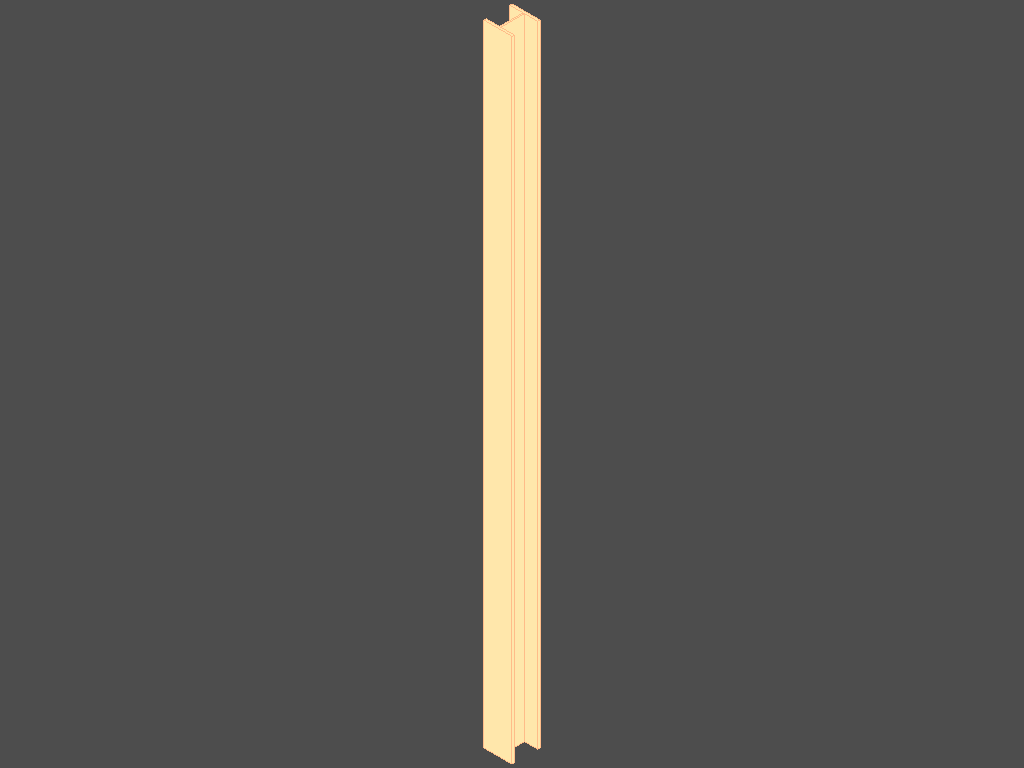

In [71]:
RenderImage(ElementsRenderFunc, elements={beam.GlobalId: beam})

### Display lines

In [72]:
beamCurves = getCurveShapes(beams)
print(len(beamCurves))
# columnCurves = getCurveShapes(columns)
curveShapes = [*beamCurves]

C:\Users\Kaare\AppData\Local\Temp\ipykernel_7892\3712244744.py:1: DeprecationWarning:

Call to deprecated function (or staticmethod) getCurveShapes. (Use processGeometry instead)



565


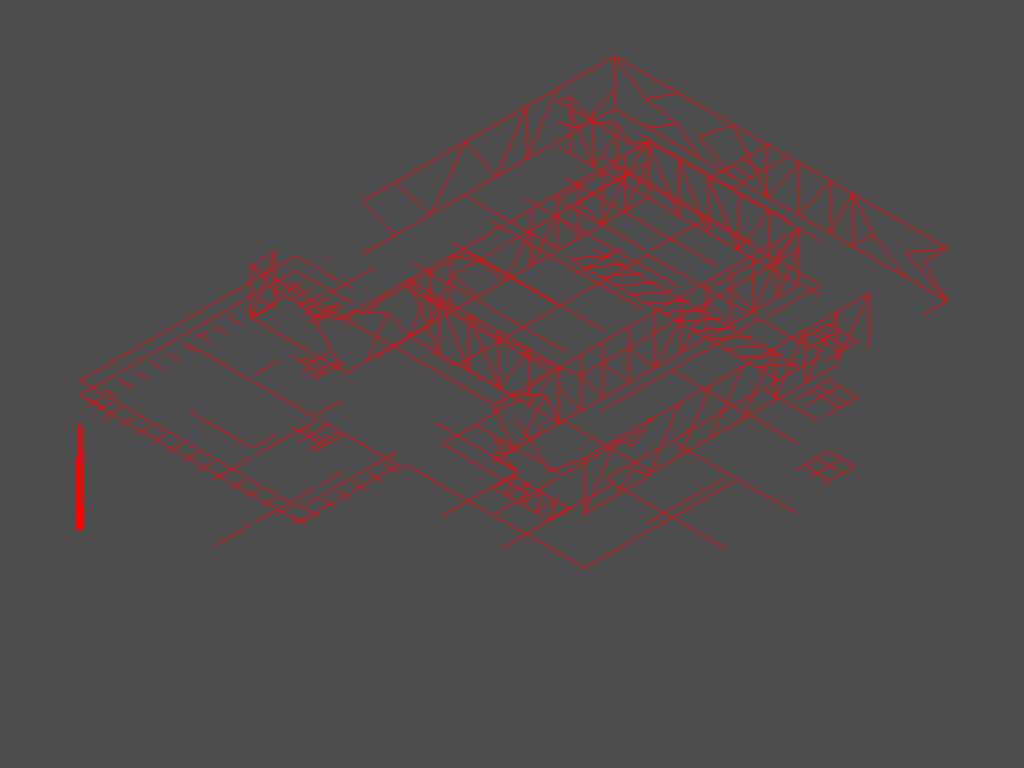

In [73]:
# RenderInWindow(SimpleRenderFunc, shapes=[curve.geometry for curve in curveShapes])
RenderImage(SimpleRenderFunc, shapes=[curve.geometry for curve in curveShapes])

## Example connections

### 3 steel beams, 1 steel column, corner

![](AdvBIM-A2_Analysis.ipynb_img/pasted_2023-10-20-11-28-53.png)

In [74]:
guids = [
    "1gWnGCa$TAouEuWitQnG6O",
    "1gWnGCa$TAouEuWitQnG8y",
    "1gWnGCa$TAouEuWitQnG5y",
    "1gWnGCa$TAouEuWitQnG6A",
    # "2RiPt4b_L7lu6usHtxHmZS", # IfcSlab above
    "1gWnGCa$TAouEuWitQnG5o", # Extras
    "1gWnGCa$TAouEuWitQnGB2",
]

In [75]:
elements = [model.by_guid(guid) for guid in guids]
elements

[#13918=IfcBeam('1gWnGCa$TAouEuWitQnG6O',#18,'H-Wide Flange Beams:SB30:1803556',$,'H-Wide Flange Beams:SB30',#13917,#13914,'1803556',.BEAM.),
 #20668=IfcBeam('1gWnGCa$TAouEuWitQnG8y',#18,'Rectangular and Square Hollow Sections:SB40:1803904',$,'Rectangular and Square Hollow Sections:SB40',#20667,#20664,'1803904',.BEAM.),
 #17051=IfcBeam('1gWnGCa$TAouEuWitQnG5y',#18,'H-Wide Flange Beams:SB30:1803712',$,'H-Wide Flange Beams:SB30',#17050,#17047,'1803712',.BEAM.),
 #14440=IfcBeam('1gWnGCa$TAouEuWitQnG6A',#18,'H-Wide Flange Beams:SB30:1803574',$,'H-Wide Flange Beams:SB30',#14439,#14436,'1803574',.BEAM.),
 #17256=IfcBeam('1gWnGCa$TAouEuWitQnG5o',#18,'H-Wide Flange Beams:SB30:1803726',$,'H-Wide Flange Beams:SB30',#17255,#17252,'1803726',.BEAM.),
 #20577=IfcBeam('1gWnGCa$TAouEuWitQnGB2',#18,'Rectangular and Square Hollow Sections:SB40:1803902',$,'Rectangular and Square Hollow Sections:SB40',#20576,#20573,'1803902',.BEAM.)]

In [76]:
def renderElementsOBB(renderer, **args):
    elements_shape = args['elements_shape']
    elements_obb = args['elements_obb']

    for GUID, pdct_shape in elements_shape.items():
        try:

            r, g, b, alpha = pdct_shape.styles[0]  # the shape color
            color = Quantity_Color(abs(r), abs(g), abs(b), Quantity_TOC_RGB)

            renderer.DisplayShape(
                # pdct_shape.geometry, shape_color=color, transparency=True, opacity=alpha
                pdct_shape.geometry,
                # pdct_shape[1],
                color=color,
                transparency=abs(1 - alpha),
                # transparency=alpha,
                # transparency=0.7,
            )

        except Exception as e:
                print(f"Error! {e}")


    for GUID, obb in elements_obb.items():
        try:
            obb_shape = convert_bnd_to_shape(obb)
            renderer.DisplayShape(obb_shape, color=rgb_color(1.0, 0.0, 1.0), transparency=0.8)

            ais_line = convert_bnd_to_line(obb)

            width = float(3.0)
            drawer = ais_line.Attributes()
            ais_line.SetWidth(width)

            # asp : first parameter color, second type, last width
            i = 1
            asp = Prs3d_LineAspect(Quantity_Color(9 * i), i, width*5.0)
            # drawer.SetLineAspect(asp)
            # drawer.SetLineArrowDraw(True)
            ais_line.SetAttributes(drawer)
            renderer.Context.Display(ais_line, False)



            textLabel = AIS_TextLabel()
            textLabel.SetPosition(gp_Pnt(obb.Center()))
            textLabel.SetText(TCollection_ExtendedString(f"{GUID}"))

            renderer.Context.Display(textLabel, False)

        except Exception as e:
                print(f"Error! {e}")

    renderer.FitAll()

In [77]:
len(load_bearing)

1750

In [78]:
# elements = [load_bearing[i] for i in range(500)]
elements = load_bearing
len(elements)

1750

In [79]:
elements = list(ifcopenshell.util.selector.filter_elements(model,
    "IfcBeam + IfcColumn, /Pset_.*Common/.LoadBearing=TRUE"))
elements = {element.GlobalId: element for element in elements}

In [80]:
# elements_shape = get_elementShapes(elements, settings)
elements_shape = {GUID: modelData.shapes[GUID]['Body'] for GUID in elements.keys()}

In [81]:
elements_obb = get_elementsOBB(elements_shape)

In [82]:
common_collisions, element_collisions = find_collisions(elements_obb)

In [83]:
# common_collisions = set([list(common_collisions)[i] for i in range(20)]) # Limit size for experiements...

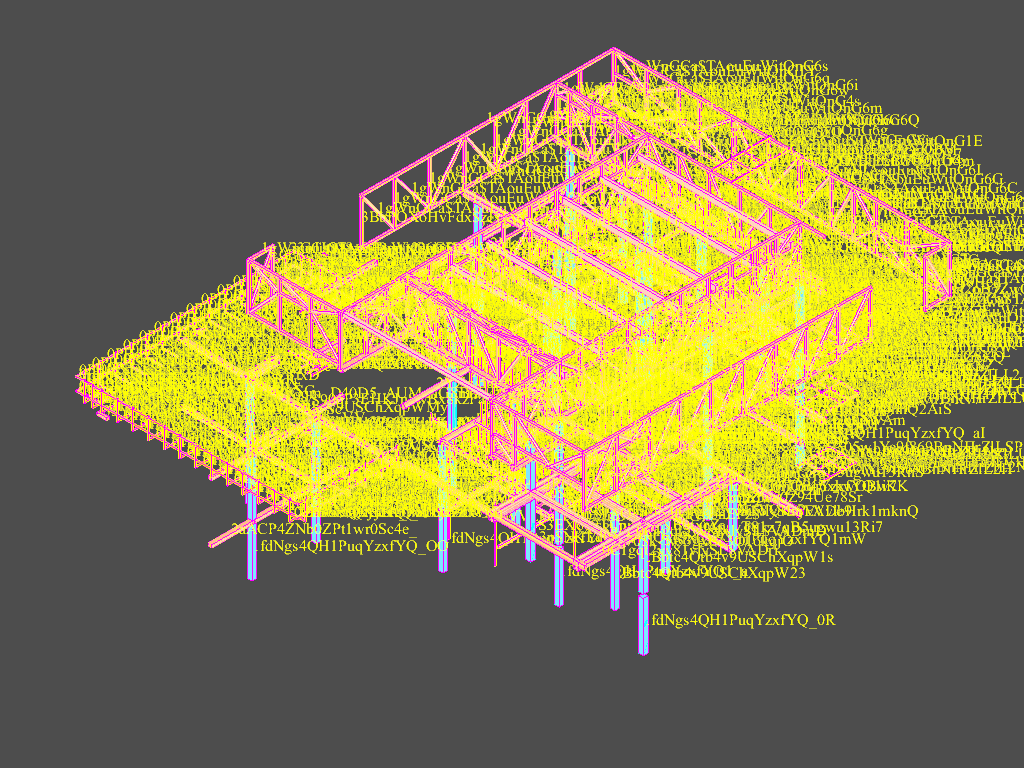

In [84]:
# RenderInWindow(renderElementsOBB, elements_shape=elements_shape, elements_obb=elements_obb)
RenderImage(renderElementsOBB, elements_shape=elements_shape, elements_obb=elements_obb)

In [85]:
collision_group_count = dict()
for collision_group in common_collisions:
    count = len(collision_group)
    
    if not collision_group_count.get(count):
        collision_group_count[count] = list()

    collision_group_count[count].append(collision_group)

[f"# {key } collisions: {len(val)}" for key, val in sorted(collision_group_count.items())]

['# 1 collisions: 115',
 '# 2 collisions: 235',
 '# 3 collisions: 194',
 '# 4 collisions: 50',
 '# 5 collisions: 168',
 '# 6 collisions: 78',
 '# 7 collisions: 46',
 '# 8 collisions: 18',
 '# 9 collisions: 10',
 '# 10 collisions: 4',
 '# 11 collisions: 4',
 '# 12 collisions: 7',
 '# 13 collisions: 5',
 '# 14 collisions: 4',
 '# 16 collisions: 3',
 '# 17 collisions: 1',
 '# 18 collisions: 1',
 '# 19 collisions: 1',
 '# 23 collisions: 2',
 '# 26 collisions: 2',
 '# 29 collisions: 3',
 '# 30 collisions: 1',
 '# 34 collisions: 1',
 '# 38 collisions: 1']

In [86]:
knots = set()
remove_knots = set()
for group in common_collisions:
    count = 0
    gknots = set()
    for GUID in group:
        obb = elements_obb[GUID]
        collisions = list()
        for GUID2 in group:
            # if GUID == GUID2: continue

            obb2 = elements_obb[GUID2]
            collides = not obb.IsOut(obb2)

            if collides:
                count += 1
                collisions.append(GUID2)

        # print(collisions)
        knots.add(tuple(collisions))
        gknots.add(tuple(collisions))

    # print(gknots)
    for gknot in gknots:
        for gknot2 in gknots:
            if gknot == gknot2: continue

            if len(gknot) <= len(gknot2): continue

            if not gknot2 in gknot:
                # print("Remove", gknot)
                remove_knots.add(gknot2)


    print(len(group), count)




3 7
3 7
2 4
6 26
2 4
3 3
5 21
12 32
3 7
23 111
1 1
3 7
6 16
1 1
16 76
5 17
6 16
7 21
2 4
4 14
2 4
3 7
2 4
2 4
3 7
2 4
5 19
3 7
2 4
3 7
3 7
7 35
2 4
6 16
3 7
2 4
2 4
3 7
4 12
3 3
4 14
6 16
5 21
1 1
2 4
3 7
4 14
7 33
1 1
2 4
2 4
3 7
7 29
3 7
5 21
1 1
3 7
2 2
3 7
2 4
3 7
1 1
5 21
2 4
6 28
8 34
13 61
2 4
11 31
12 34
1 1
2 2
3 7
2 4
14 40
10 42
4 12
5 21
5 21
5 19
2 4
5 21
9 25
1 1
3 5
2 4
3 7
3 5
2 4
5 19
5 19
5 13
5 11
5 19
5 17
1 1
2 4
5 19
5 17
14 40
4 12
2 4
4 14
2 4
13 65
2 4
5 21
2 4
7 27
2 4
3 7
2 4
3 7
14 40
3 7
5 19
3 7
2 4
3 7
6 28
7 37
3 7
2 4
3 7
5 21
1 1
7 19
2 4
1 1
2 4
5 21
5 21
5 21
3 7
5 21
5 17
7 29
5 21
6 16
4 14
5 21
5 17
7 27
5 21
3 7
12 54
3 7
3 7
1 1
2 4
3 7
9 39
1 1
4 10
3 5
6 16
1 1
6 30
2 4
2 2
5 17
34 164
2 4
2 4
3 7
3 7
5 21
3 7
2 4
3 3
3 7
2 4
3 7
2 4
2 4
5 21
1 1
5 19
3 7
1 1
5 23
1 1
5 15
2 4
5 21
7 29
3 7
7 35
1 1
5 19
2 4
4 12
3 7
8 32
3 7
5 21
6 16
3 7
2 4
6 28
5 21
2 2
4 10
3 7
1 1
3 7
5 17
6 24
4 14
11 51
3 7
16 76
2 4
2 4
3 9
5 21
5 21
2 4
3 3
1 1
1 1
5

In [87]:
true_knots = remove_knots.intersection(knots)
# true_knots

In [88]:
# print(len(common_collisions))
# count = 3
# collision_group = collision_group_count[count][0]

# collision_group = list(knots)[1]
collision_group = list(true_knots)[500]
print(len(true_knots))

elements_group = [model.by_guid(GUID) for GUID in collision_group]
selected_guids = collision_group
selected_guids = list(common_collisions)[41]
len(elements_group)

1426


2

In [89]:
collision_group = list(common_collisions)[41]
collision_group

('0PBox$QKjEKQwoUJvZkw7P',
 '0PBox$QKjEKQwoUJvZkxfI',
 '0PBox$QKjEKQwoUJvZkxfS',
 '0PBox$QKjEKQwoUJvZkxsX',
 '0PBox$QKjEKQwoUJvZkxsd',
 '3cgthokUX8HuAcV5wVTtsL')

In [90]:
GUID = '0785r_tan1DgBgGMKaJe1a'
selected_guids = [GUID, *element_collisions[GUID]]

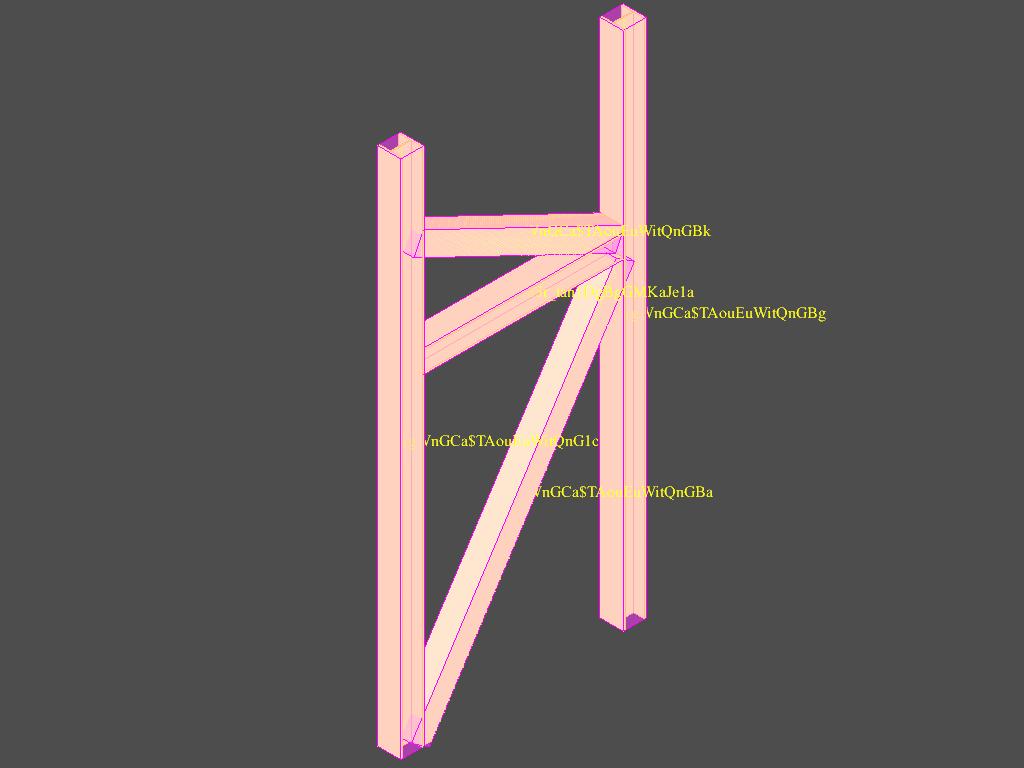

In [91]:
selected_obb = {GUID: elements_obb.get(GUID) for GUID in selected_guids}
selected_shapes = {GUID: elements_shape.get(GUID) for GUID in selected_guids}

# RenderInWindow(ElementsRenderFunc, elements={element.GlobalId: element for element in elements_group})
# RenderImage(ElementsRenderFunc, elements={element.GlobalId: element for element in elements_group})
# RenderInWindow(renderElementsOBB, elements_shape=selected_shapes, elements_obb=selected_obb)
RenderImage(renderElementsOBB, elements_shape=selected_shapes, elements_obb=selected_obb)

In [92]:
column = '1gWnGCa$TAouEuWitQnG6O'
beam1 = '1gWnGCa$TAouEuWitQnG8y' # Diagonal
beam2 = '1gWnGCa$TAouEuWitQnG5y'
beam3 = '1gWnGCa$TAouEuWitQnG6A' # Long
beam3 = '1gWnGCa$TAouEuWitQnG6A' # Long

selected_guids = {
    column, beam1, beam2, beam3
}

selected_obb = {GUID: elements_obb.get(GUID) for GUID in selected_guids}
selected_shapes = {GUID: elements_shape.get(GUID) for GUID in selected_guids}

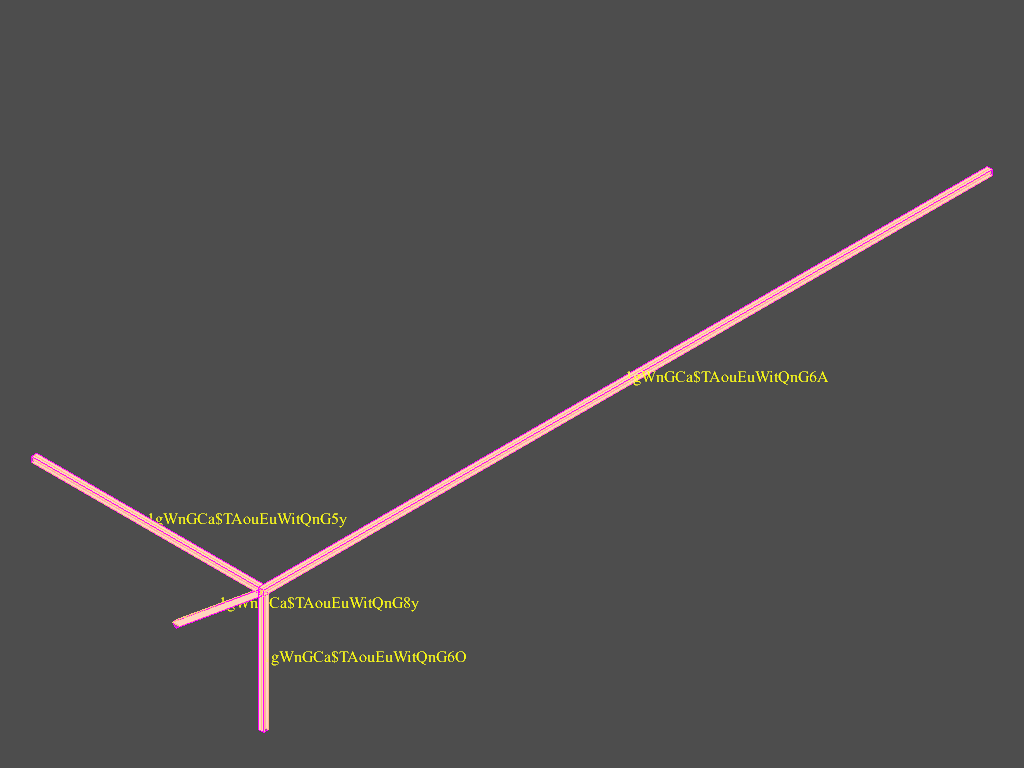

In [93]:
RenderImage(renderElementsOBB, elements_shape=selected_shapes, elements_obb=selected_obb)

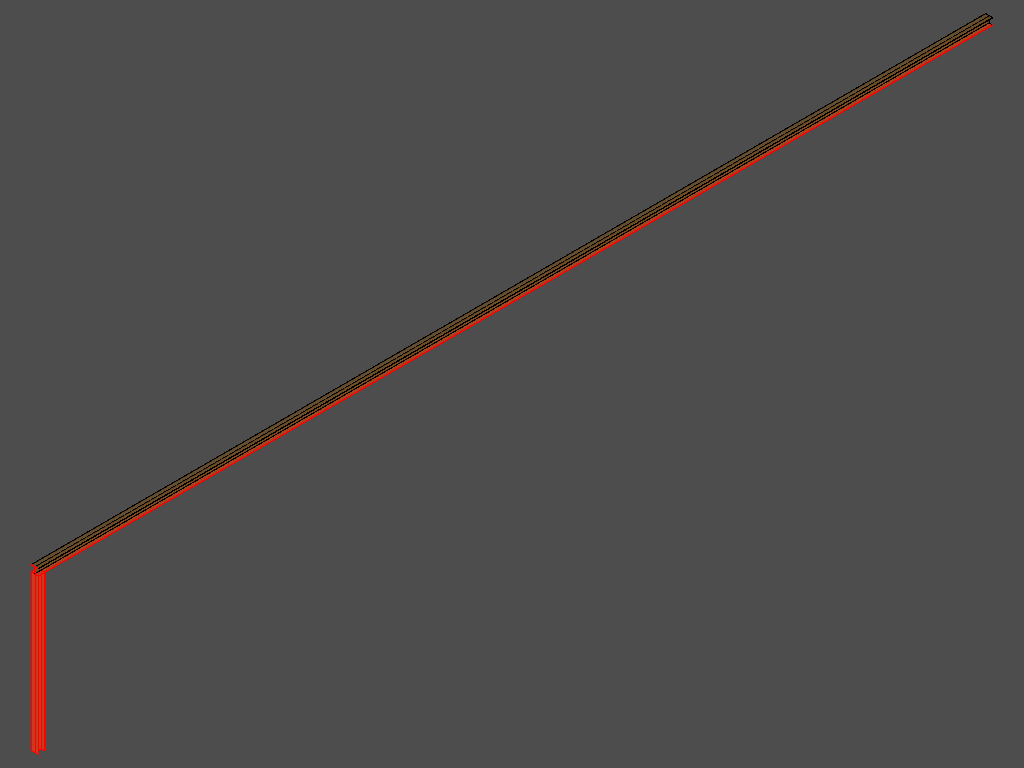

In [94]:
def renderIntersect(renderer, **args):

    box1 = elements_shape[column].geometry
    box2 = elements_shape[beam3].geometry

    # create two boxes that intersect
    # box1 = BRepPrimAPI_MakeBox(gp_Pnt(0, 0, 0), gp_Pnt(20, 20, 20)).Shape()
    # box2 = BRepPrimAPI_MakeBox(gp_Pnt(20.01, 10, 10), gp_Pnt(30, 30, 30)).Shape()

    # Create meshes for the proximity algorithm
    deflection = 1e-3
    mesher1 = BRepMesh_IncrementalMesh(box1, deflection)
    mesher2 = BRepMesh_IncrementalMesh(box2, deflection)
    mesher1.Perform()
    mesher2.Perform()

    # Perform shape proximity check
    tolerance = 0.000005
    isect_test = BRepExtrema_ShapeProximity(box1, box2, tolerance)
    isect_test.Perform()

    # Get intersecting faces from Shape1
    overlaps1 = isect_test.OverlapSubShapes1()
    face_indices1 = overlaps1.Keys()
    shape_1_faces = []
    for ind in face_indices1:
        face = isect_test.GetSubShape1(ind)
        shape_1_faces.append(face)

    # Get intersecting faces from Shape2
    overlaps2 = isect_test.OverlapSubShapes2()
    face_indices2 = overlaps2.Keys()
    shape_2_faces = []
    for ind in face_indices2:
        face = isect_test.GetSubShape2(ind)
        shape_2_faces.append(face)

    # renderer both boxes and intersecting faces, in RED
    renderer.DisplayShape(box1, transparency=0.5)
    renderer.DisplayShape(box2, transparency=0.5)
    renderer.DisplayShape(shape_1_faces + shape_2_faces, color="RED")
    # renderer.DisplayShape(shape_1_faces, color="RED")
    # print(overlaps1.Get)

    # subshp1 = isect_test.
    # print(subshp1)
    # renderer.DisplayShape(subshp1, color="RED")

    renderer.FitAll()

RenderImage(renderIntersect)

Minimal distance between cubes:  1.70174985214544e-12
12
False


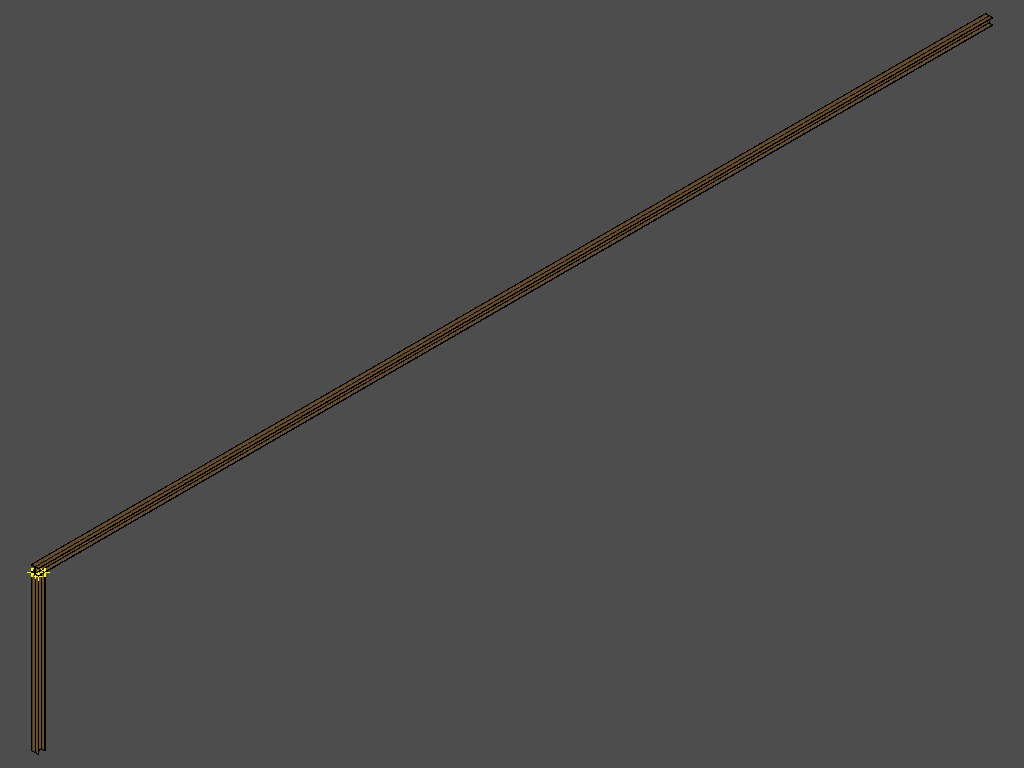

In [95]:
from OCC.Core.BRepExtrema import BRepExtrema_DistShapeShape
# import OCC.Core.BRepExtrema
from OCC.Extend.ShapeFactory import make_edge, make_vertex


# https://old.opencascade.com/doc/occt-7.5.0/refman/html/class_b_rep_extrema___dist_shape_shape.html
def renderIntersect2(renderer, **args):

    b1 = elements_shape[column].geometry
    b2 = elements_shape[beam3].geometry
    # b2 = elements_shape['1qi89aVqvCRRthDWCeA1T0'].geometry

    # b1 = BRepPrimAPI_MakeBox(gp_Pnt(100, 0, 0), 10.0, 10.0, 10.0).Shape()
    # b2 = BRepPrimAPI_MakeBox(gp_Pnt(45, 45, 45), 10.0, 10.0, 10.0).Shape()
    renderer.DisplayShape([b1, b2], transparency=0.5)

    dss = BRepExtrema_DistShapeShape()
    dss.LoadS1(b1)
    dss.LoadS2(b2)
    dss.Perform()

    assert dss.IsDone()

    print("Minimal distance between cubes: ", dss.Value())


    print(dss.NbSolution())
    print(dss.InnerSolution())
    for i in range(dss.NbSolution()):
        edg = make_edge(dss.PointOnShape1(1 + i), dss.PointOnShape2(1 + i))
        renderer.DisplayColoredShape([edg], color="CYAN")

        renderer.DisplayShape(dss.PointOnShape1(1 + i))
        renderer.DisplayShape(dss.PointOnShape2(1 + i))
        # print(dss.SupportTypeShape1(1+i))
    

    renderer.FitAll()

# RenderInWindow(renderIntersect2)
RenderImage(renderIntersect2)

In [96]:
guids_inBox = {elm.GlobalId for elm in modelData.tree.select((8.0,10.0,3.0), extend=20.0)}
len(guids_inBox)

1198

In [97]:
elements_guids = {elm.GlobalId for elm in
                  list(ifcopenshell.util.selector.filter_elements(model,
                    "IfcBeam + IfcColumn, /Pset_.*Common/.LoadBearing=TRUE"))
                    }
len(elements_guids)

1017

In [98]:
# selected_guids = guids_inBox.intersection(elements_guids)
selected_guids = elements_guids
len(selected_guids)

1017

In [99]:
# some_collisions = {list(element_collisions.keys())[i]: list(element_collisions.values())[i] for i in range(100)}
some_collisions = {GUID: element_collisions[GUID] for GUID in selected_guids}
len(some_collisions)

1017

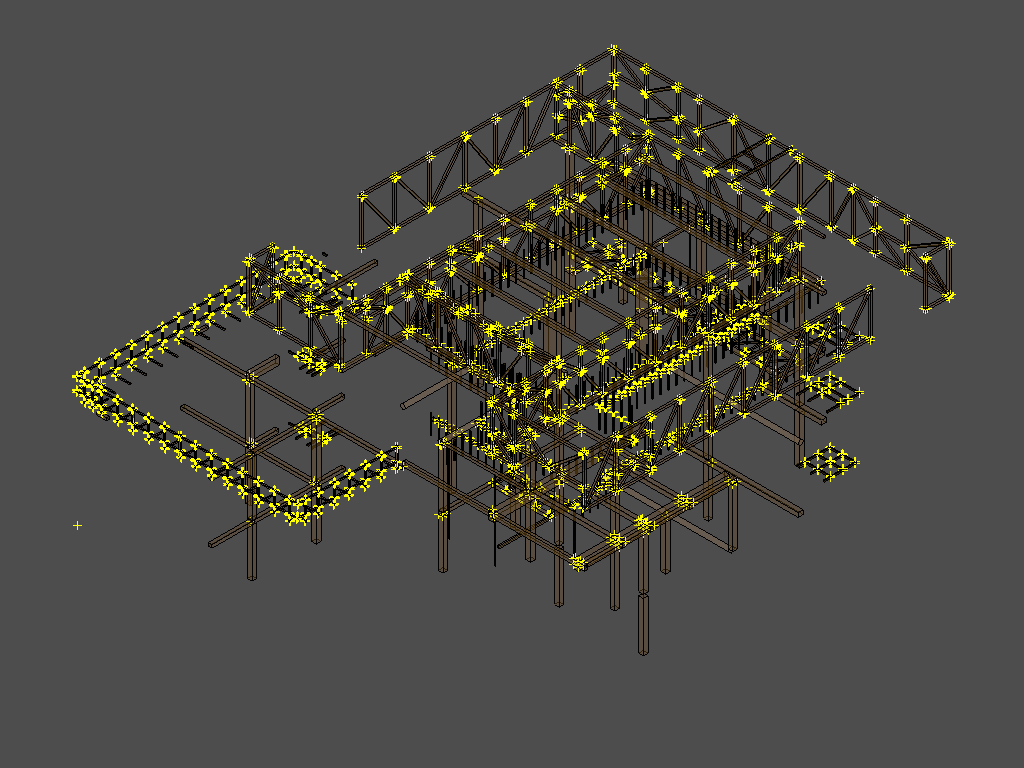

In [100]:
# https://old.opencascade.com/doc/occt-7.5.0/refman/html/class_b_rep_extrema___dist_shape_shape.html
def renderIntersect3(renderer, **args):
    element_collisions = args['element_collisions']

    for this, others in element_collisions.items():
        this_obb_ = elements_obb[this]
        this_obb = Bnd_OBB()
        this_obb.Add(this_obb_)
        this_obb.Enlarge(0.001)
        b1 = convert_bnd_to_shape(this_obb)
        renderer.DisplayShape(b1, transparency=0.8)
        
        for other in others:
            other_obb = elements_obb[other]
            b2 = convert_bnd_to_shape(other_obb)


            # renderer.DisplayShape([b1, b2], transparency=0.8)

            dss = BRepExtrema_DistShapeShape()
            dss.LoadS1(b1)
            dss.LoadS2(b2)
            dss.Perform()

            assert dss.IsDone()

            # print("Minimal distance between cubes: ", dss.Value())


            # print(dss.NbSolution())
            # print(dss.InnerSolution())
            for i in range(dss.NbSolution()):
                # edg = make_edge(dss.PointOnShape1(1 + i), dss.PointOnShape2(1 + i))
                # renderer.DisplayColoredShape([edg], color="CYAN")

                renderer.DisplayShape(dss.PointOnShape1(1 + i))
                renderer.DisplayShape(dss.PointOnShape2(1 + i))
                # print(dss.SupportTypeShape1(1+i))
        

    renderer.FitAll()

# collisions = element_collisions
collisions = some_collisions
# RenderInWindow(renderIntersect3, element_collisions=collisions)
RenderImage(renderIntersect3, element_collisions=collisions)

Standard_ConstructionErrorgp_Dir() - input vector has zero norm raised from method gp_Dir of class gp_Dir
Standard_ConstructionErrorgp_Dir() - input vector has zero norm raised from method gp_Dir of class gp_Dir
Standard_ConstructionErrorgp_Dir() - input vector has zero norm raised from method gp_Dir of class gp_Dir
Standard_ConstructionErrorgp_Dir() - input vector has zero norm raised from method gp_Dir of class gp_Dir
Standard_ConstructionErrorgp_Dir() - input vector has zero norm raised from method gp_Dir of class gp_Dir
Standard_ConstructionErrorgp_Dir() - input vector has zero norm raised from method gp_Dir of class gp_Dir
Standard_ConstructionErrorgp_Dir() - input vector has zero norm raised from method gp_Dir of class gp_Dir
Standard_ConstructionErrorgp_Dir() - input vector has zero norm raised from method gp_Dir of class gp_Dir
Standard_ConstructionErrorgp_Dir() - input vector has zero norm raised from method gp_Dir of class gp_Dir
Standard_ConstructionErrorgp_Dir() - input vec

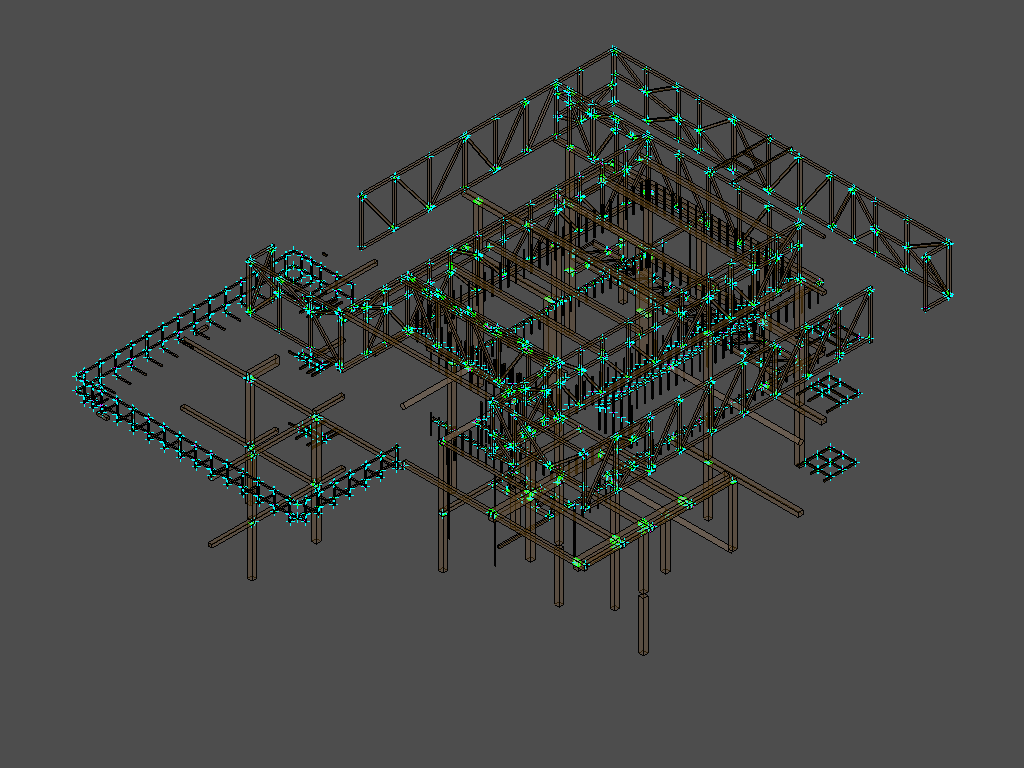

In [101]:
# https://old.opencascade.com/doc/occt-7.5.0/refman/html/class_b_rep_extrema___dist_shape_shape.html
def renderIntersect4(renderer, **args):
    element_collisions = args['element_collisions']

    global points
    global intersection_obbs
    points = list()
    intersection_obbs = list()

    i = 0
    #    GUID, GUID
    for this, others in element_collisions.items():
        this_obb_ = elements_obb[this]
        this_obb = Bnd_OBB()
        this_obb.Add(this_obb_)
        this_obb.Enlarge(0.001)
        b1 = convert_bnd_to_shape(this_obb)
        renderer.DisplayShape(b1, transparency=0.8)
        
        for other in others:
            try:
                other_obb = elements_obb[other]
                b2 = convert_bnd_to_shape(other_obb)

                solidIntersection = BRepAlgoAPI_Common(b1, b2).Shape()

                intersection_obb = get_OBB(solidIntersection)
                intersection_obbs.append(intersection_obb)
                intersecion_shp = convert_bnd_to_shape(intersection_obb)
                centerPnt = gp_Pnt(intersection_obb.Center())

                points.append(centerPnt)

                color = Quantity_Color(1.0, 0.0, 1.0, Quantity_TOC_RGB)
                i += 1
                to_update = i % 50 == 0
                if to_update: i = 0
                renderer.DisplayShape(solidIntersection,
                                    color=color,
                                    transparency=0.8,
                                    update=to_update)
                

                color = Quantity_Color(0.0, 1.0, 0.0, Quantity_TOC_RGB)
                renderer.DisplayShape(
                    intersecion_shp,
                    color=color,
                )

                color = Quantity_Color(0.0, 1.0, 1.0, Quantity_TOC_RGB)
                renderer.DisplayShape(
                    centerPnt,
                    color=color,
                )
            except Exception as e:
                print(e)

            # dss = BRepExtrema_DistShapeShape()
            # dss.LoadS1(b1)
            # dss.LoadS2(b2)
            # dss.Perform()

            # assert dss.IsDone()

            # # print("Minimal distance between cubes: ", dss.Value())


            # # print(dss.NbSolution())
            # # print(dss.InnerSolution())
            # for i in range(dss.NbSolution()):
            #     # edg = make_edge(dss.PointOnShape1(1 + i), dss.PointOnShape2(1 + i))
            #     # renderer.DisplayColoredShape([edg], color="CYAN")

            #     renderer.DisplayShape(dss.PointOnShape1(1 + i))
            #     renderer.DisplayShape(dss.PointOnShape2(1 + i))
            #     # print(dss.SupportTypeShape1(1+i))
        

    renderer.FitAll()
    print("Done...")

# collisions = element_collisions
collisions = some_collisions
# RenderInWindow(renderIntersect4, element_collisions=collisions)
RenderImage(renderIntersect4, element_collisions=collisions)

In [102]:
print(len(points))
print(len(intersection_obbs))

3008
3022


In [103]:
new_obbs = list()
for obb in intersection_obbs:
    collisionCount = 0
    for new_obb in new_obbs:
        collides = not obb.IsOut(new_obb)
        if collides:
            new_obb.Add(obb)
            collisionCount += 1
    
    if collisionCount == 0:
        new_obb = Bnd_OBB()
        new_obb.Add(obb)
        new_obbs.append(new_obb)
    
    if collisionCount > 1:
        print(f"Warning! Collision Count: {collisionCount}!")

len(new_obbs)

Warning! Collision Count: 2!
Warning! Collision Count: 2!
Warning! Collision Count: 2!
Warning! Collision Count: 2!
Warning! Collision Count: 2!
Warning! Collision Count: 2!
Warning! Collision Count: 2!
Warning! Collision Count: 2!
Warning! Collision Count: 2!
Warning! Collision Count: 2!
Warning! Collision Count: 2!
Warning! Collision Count: 2!
Warning! Collision Count: 2!
Warning! Collision Count: 2!
Warning! Collision Count: 2!
Warning! Collision Count: 2!
Warning! Collision Count: 3!
Warning! Collision Count: 2!
Warning! Collision Count: 2!
Warning! Collision Count: 2!
Warning! Collision Count: 2!
Warning! Collision Count: 2!
Warning! Collision Count: 2!
Warning! Collision Count: 2!
Warning! Collision Count: 2!
Warning! Collision Count: 2!
Warning! Collision Count: 2!
Warning! Collision Count: 2!
Warning! Collision Count: 2!
Warning! Collision Count: 2!
Warning! Collision Count: 2!
Warning! Collision Count: 2!
Warning! Collision Count: 2!
Warning! Collision Count: 2!
Warning! Colli

970

In [104]:
obbs = list()
for new_obb in new_obbs:
    obb = Bnd_OBB()
    obb.Add(new_obb)
    obb.Enlarge(0.01)

    obbs.append(obb)

common_obbs = list()
for obb in obbs:
    collisionCount = 0

    for common_obb in common_obbs:
        collides = not obb.IsOut(common_obb)
        if collides:
            common_obb.Add(obb)
            collisionCount += 1
    
    if collisionCount == 0:
        common_obb = Bnd_OBB()
        common_obb.Add(obb)
        common_obbs.append(common_obb)
    
    if collisionCount > 1:
        print(f"Warning! Collision Count: {collisionCount}!")

len(common_obbs)

873

Standard_ConstructionErrorgp_Dir() - input vector has zero norm raised from method gp_Dir of class gp_Dir
Standard_ConstructionErrorgp_Dir() - input vector has zero norm raised from method gp_Dir of class gp_Dir
Standard_ConstructionErrorgp_Dir() - input vector has zero norm raised from method gp_Dir of class gp_Dir
Standard_ConstructionErrorgp_Dir() - input vector has zero norm raised from method gp_Dir of class gp_Dir
Standard_ConstructionErrorgp_Dir() - input vector has zero norm raised from method gp_Dir of class gp_Dir
Standard_ConstructionErrorgp_Dir() - input vector has zero norm raised from method gp_Dir of class gp_Dir
Standard_ConstructionErrorgp_Dir() - input vector has zero norm raised from method gp_Dir of class gp_Dir
Standard_ConstructionErrorgp_Dir() - input vector has zero norm raised from method gp_Dir of class gp_Dir
Standard_ConstructionErrorgp_Dir() - input vector has zero norm raised from method gp_Dir of class gp_Dir
Standard_ConstructionErrorgp_Dir() - input vec

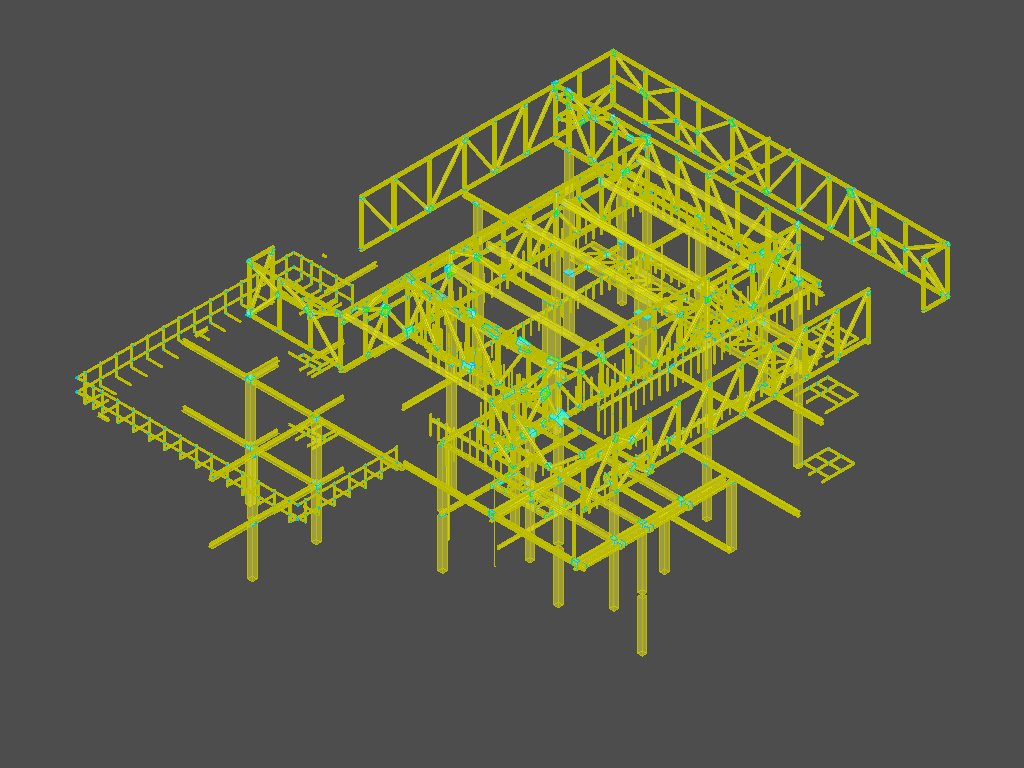

In [105]:
def renderObbs(renderer, **args):
    obbs = args['obbs']
    common_obbs = args['common_obbs']
    guids = args['guids']
    modelData = args['modelData']

    for i, GUID in enumerate(guids):
        to_update = i % 50 == 0

        shape = modelData.shapes[GUID]['Body']

        color = Quantity_Color(0.5, 0.5, 0.0, Quantity_TOC_RGB)
        renderer.DisplayShape(
                shape.geometry,
                color=color,
                transparency=0.8,
                update=to_update,
        )

    for i, obb in enumerate(obbs):
        try:
            to_update = i % 50 == 0
            
            obb_shp = convert_bnd_to_shape(obb)

            color = Quantity_Color(0.0, 1.0, 0.0, Quantity_TOC_RGB)
            renderer.DisplayShape(
                    obb_shp,
                    color=color,
                    transparency=0.5,
                    update=to_update,
            )
        except Exception as e:
            print(e)

    for i, obb in enumerate(common_obbs):
        try:
            to_update = i % 50 == 0
            
            obb_shp = convert_bnd_to_shape(obb)

            color = Quantity_Color(0.0, 0.5, 1.0, Quantity_TOC_RGB)
            renderer.DisplayShape(
                    obb_shp,
                    color=color,
                    transparency=0.5,
                    update=to_update,
            )
        except Exception as e:
            print(e)

    renderer.FitAll()
    print("Done...")


# RenderInWindow(renderObbs, obbs=new_obbs, common_obbs=common_obbs, modelData=modelData, guids=selected_guids)
RenderImage(renderObbs, obbs=new_obbs, common_obbs=common_obbs, modelData=modelData, guids=selected_guids)

## Other stuff

In [106]:
# Create Box
# axe = gp_Ax2(gp_Pnt(10, 10, 10), gp_Dir(1, 2, 1))
# Box = BRepPrimAPI_MakeBox(axe, 60, 80, 100).Shape()
# # # Create wedge
# Wedge = BRepPrimAPI_MakeWedge(60.0, 100.0, 80.0, 20.0).Shape()
# Common surface


# Box = convert_bnd_to_shape(elements_obb[column])
# Wedge = convert_bnd_to_shape(elements_obb[beam3])


# Box = elements_obb[column]
# Wedge = elements_obb[beam1]

Box = elements_shape[column].geometry
Wedge = elements_shape[beam1].geometry

CommonSurface = BRepAlgoAPI_Common(Box, Wedge).Shape()

common_obb = get_OBB(CommonSurface)
# common_obb.Enlarge(0.2)
common_obbShp = convert_bnd_to_shape(common_obb)

print(f"Box: {Box}")
print(f"Wedge: {Wedge}")
print(f"CommonSurface: {CommonSurface}")
print(f"Common_obb: {common_obb}")
print(f"Common_obbShp: {common_obbShp}")

Box: <class 'TopoDS_Compound'>
Wedge: <class 'TopoDS_Compound'>
CommonSurface: <class 'TopoDS_Compound'>
Common_obb: <class 'Bnd_OBB'>
Common_obbShp: <class 'TopoDS_Solid'>


In [107]:
def renderFunc(renderer, **args):
    
    try:
        renderer.EraseAll()
        ais_box = renderer.DisplayShape(Box)[0]
        ais_wedge = renderer.DisplayShape(Wedge)[0]
        renderer.Context.SetTransparency(ais_box, 0.8, True)
        renderer.Context.SetTransparency(ais_wedge, 0.8, True)
        renderer.DisplayShape(common_obbShp, color=rgb_color(0.0, 1.0, 1.0), transparency=0.5)
        renderer.DisplayShape(CommonSurface, color=rgb_color(1.0, 0.0, 1.0),transparency=0.5)    
        
        bbox, bboxShp = FitToShape(renderer, common_obbShp)
        # renderer.DisplayShape(bboxShp, color=rgb_color(0.0, 1.0, 0.0),transparency=0.5)

        # renderer.SetModeWireFrame()
        # renderer.FitAll()

    except Exception as e:
        print(f"Exception!: {e}")

    print(args)


{'testarg': 'abc'}


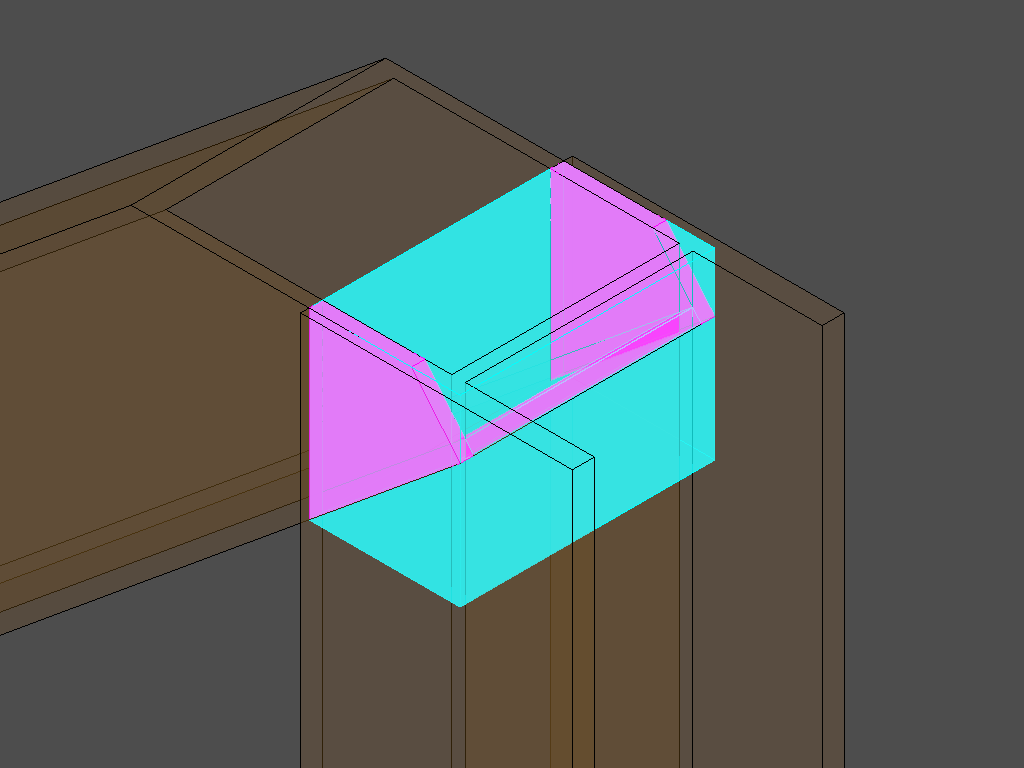

In [108]:
RenderImage(renderFunc,  testarg='abc')

**Tests**...:

In [109]:
beam = model.by_guid(guids[0])
beam

#13918=IfcBeam('1gWnGCa$TAouEuWitQnG6O',#18,'H-Wide Flange Beams:SB30:1803556',$,'H-Wide Flange Beams:SB30',#13917,#13914,'1803556',.BEAM.)

In [110]:
elements = modelData.tree.select_box(beam, extend=0.001)
elements

[#12571=IfcBeam('1gWnGCa$TAouEuWitQnG1a',#18,'Rectangular and Square Hollow Sections:SB40:1803480',$,'Rectangular and Square Hollow Sections:SB40',#12570,#12567,'1803480',.BEAM.),
 #13918=IfcBeam('1gWnGCa$TAouEuWitQnG6O',#18,'H-Wide Flange Beams:SB30:1803556',$,'H-Wide Flange Beams:SB30',#13917,#13914,'1803556',.BEAM.),
 #13918=IfcBeam('1gWnGCa$TAouEuWitQnG6O',#18,'H-Wide Flange Beams:SB30:1803556',$,'H-Wide Flange Beams:SB30',#13917,#13914,'1803556',.BEAM.),
 #17051=IfcBeam('1gWnGCa$TAouEuWitQnG5y',#18,'H-Wide Flange Beams:SB30:1803712',$,'H-Wide Flange Beams:SB30',#17050,#17047,'1803712',.BEAM.),
 #17256=IfcBeam('1gWnGCa$TAouEuWitQnG5o',#18,'H-Wide Flange Beams:SB30:1803726',$,'H-Wide Flange Beams:SB30',#17255,#17252,'1803726',.BEAM.),
 #14440=IfcBeam('1gWnGCa$TAouEuWitQnG6A',#18,'H-Wide Flange Beams:SB30:1803574',$,'H-Wide Flange Beams:SB30',#14439,#14436,'1803574',.BEAM.),
 #20668=IfcBeam('1gWnGCa$TAouEuWitQnG8y',#18,'Rectangular and Square Hollow Sections:SB40:1803904',$,'Rectangu

In [111]:
project = model.by_type('IfcProject')[0]
project

#93=IfcProject('3yHhRiYMfCAOAtv2MmnXRn',#18,'17-0279',$,$,'LLYN.B374','AS BUILT',(#86,#91),#82)

In [112]:
project.UnitsInContext

#82=IfcUnitAssignment((#19,#21,#22,#26,#27,#30,#31,#33,#34,#35,#37,#40,#42,#46,#47,#48,#49,#50,#51,#52,#53,#54,#55,#60,#62,#64,#67,#68,#69,#70,#71,#72,#73,#74,#76,#77,#78,#79,#80,#81))

In [113]:
ifcopenshell.util.unit.get_project_unit(model, 'LENGTHUNIT')

#19=IfcSIUnit(*,.LENGTHUNIT.,.MILLI.,.METRE.)

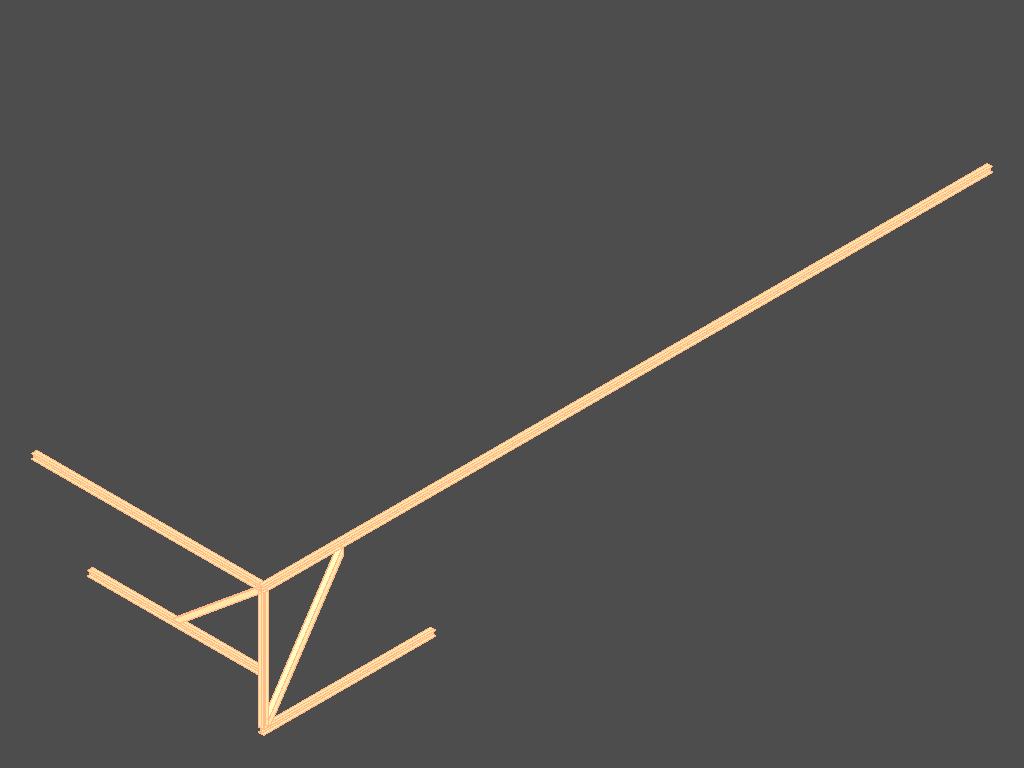

In [114]:
RenderImage(ElementsRenderFunc, elements={element.GlobalId: element for element in elements})

In [115]:
guids

['1gWnGCa$TAouEuWitQnG6O',
 '1gWnGCa$TAouEuWitQnG8y',
 '1gWnGCa$TAouEuWitQnG5y',
 '1gWnGCa$TAouEuWitQnG6A',
 '1gWnGCa$TAouEuWitQnG5o',
 '1gWnGCa$TAouEuWitQnGB2']

Length of list: 6


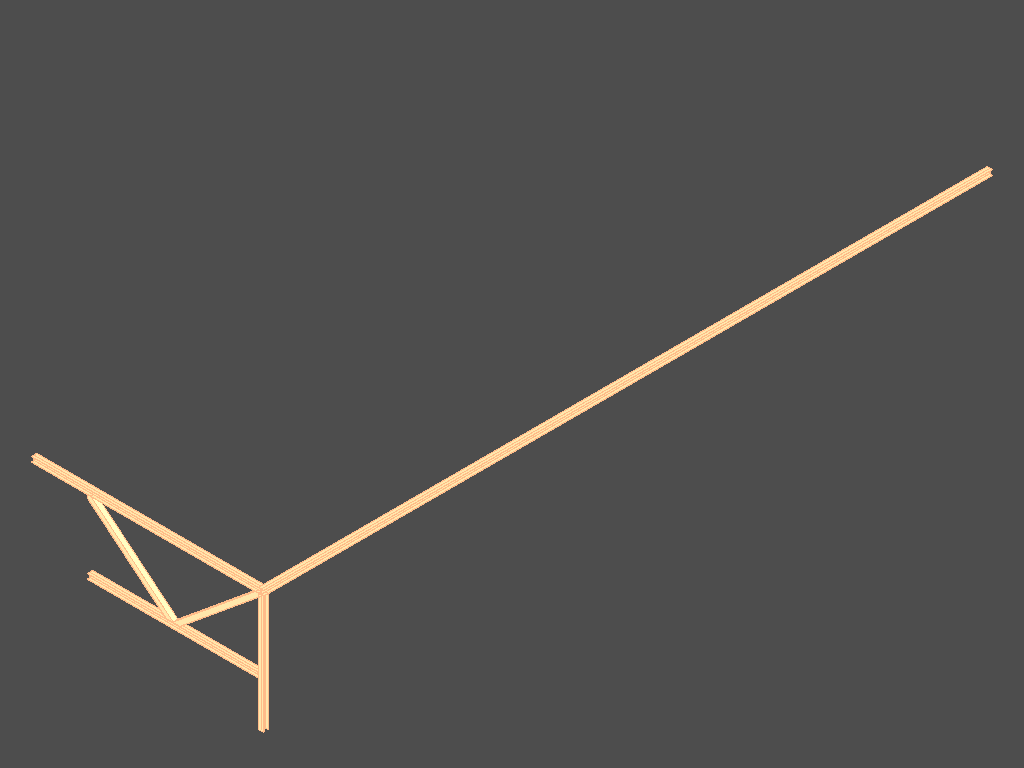

In [116]:
elements_render = utils.getElementsRender(guids, model)
RenderImage(ElementsRenderFunc, elements={element.GlobalId: element for element in elements_render})

### 3 steel beams, middle of beam

![](AdvBIM-A2_Analysis.ipynb_img/pasted_2023-10-20-11-30-59.png)

In [117]:
guids = [
    "1gWnGCa$TAouEuWitQnG5o",
    "1gWnGCa$TAouEuWitQnG8y",
    "1gWnGCa$TAouEuWitQnGB2",
]

Length of list: 3


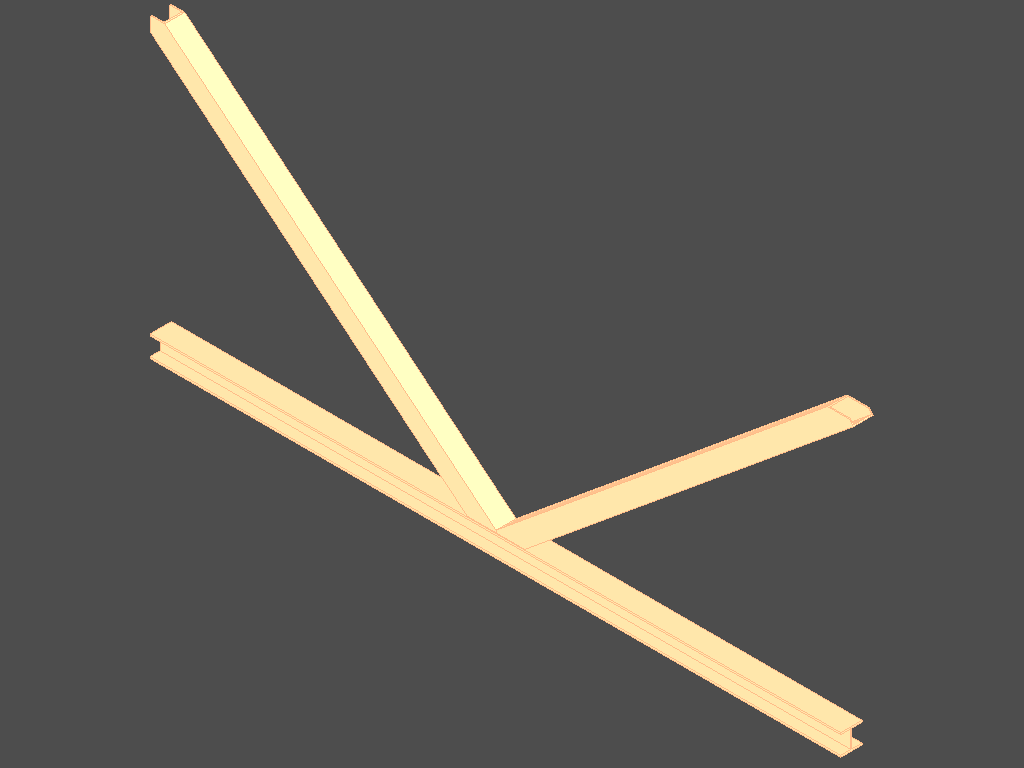

In [118]:
elements_render = utils.getElementsRender(guids, model)
RenderImage(ElementsRenderFunc, elements={element.GlobalId: element for element in elements_render})